In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from prophet import Prophet

### Loading datasets

In [3]:
def load_data(file_path1, file_path2):
    df1 = pd.read_csv(file_path1)  # All countries global temperature
    df2 = pd.read_csv(file_path2)  # Average Surface Temperature
    return df1, df2

file_path1 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\all countries global temperature.csv"
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df1, df2 = load_data(file_path1, file_path2)

### Exploratory Data Analysis (EDA)


In [4]:
def perform_eda(df):
    print("Shape of dataframe:", df.shape)
    print("\nColumns in dataframe:", df.columns.tolist())
    print("\nFirst 5 rows of dataframe:")
    print(df.head())
    print("\nLast 5 rows of dataframe:")
    print(df.tail())
    print("\nSummary statistics for numerical columns:")
    print(df.describe())
    print("\nMissing values in dataframe:")
    print(df.isnull().sum())
    print("\nNumber of unique countries:", df['Country Name'].nunique())

perform_eda(df1)
perform_eda(df2)

Shape of dataframe: (227, 56)

Columns in dataframe: ['ObjectId', 'Country Name', 'Unit', 'Change ', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

First 5 rows of dataframe:
   ObjectId                  Country Name            Unit  \
0         1  Afghanistan, Islamic Rep. of  Degree Celsius   
1         2                       Albania  Degree Celsius   
2         3                       Algeria  Degree Celsius   
3         4                American Samoa  Degree Celsius   
4         5      Andorra, Principality of  Degree Celsius   

                      Change    1970   1971   1972   1973   1974   1975  ...  \
0  Surfa

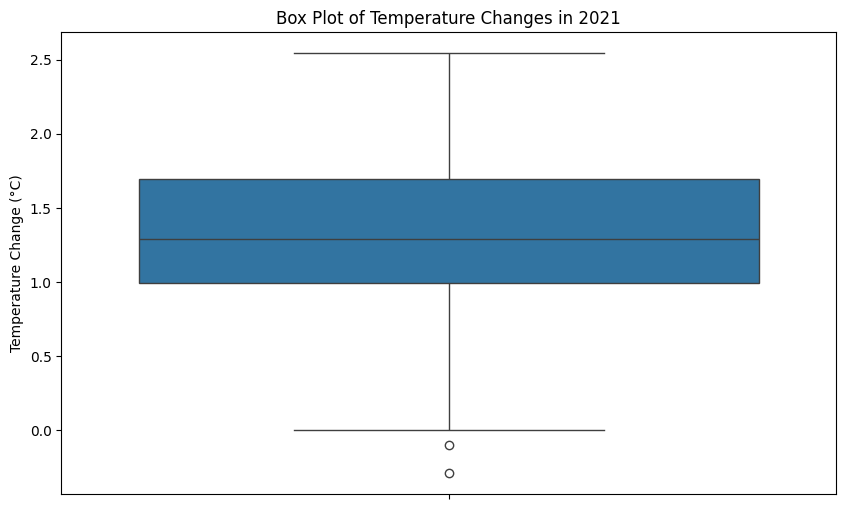

In [5]:
def plot_boxplot(df, year_column, title):
    """
    Plot a box plot for temperature changes in a specific year.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, y=year_column)
    plt.title(title)
    plt.ylabel("Temperature Change (°C)")
    plt.show()

# Example: Box plot for temperature changes in 2021
plot_boxplot(df1, '2021', "Box Plot of Temperature Changes in 2021")

### BOXPLOT FOR KENYA

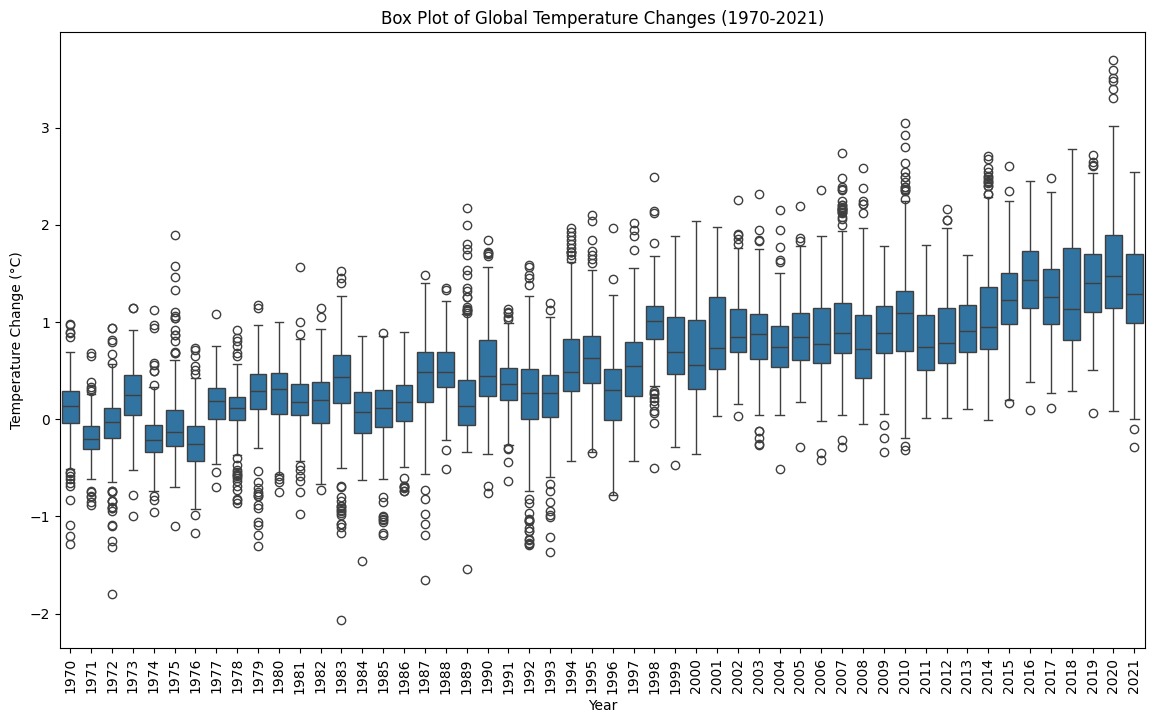

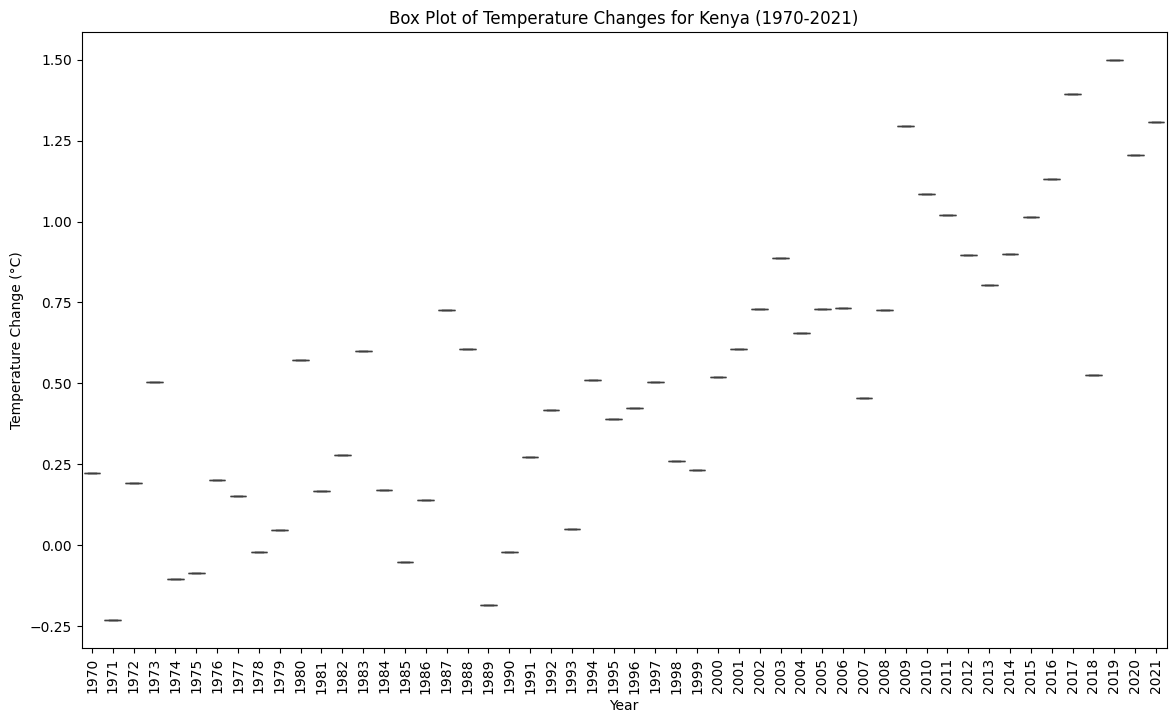

In [6]:
def plot_boxplot_all_years(df, country_name=None):
    """
    Plot a box plot for temperature changes across all years.
    If country_name is provided, filter data for that country.
    """
    if country_name:
        df_filtered = df[df['Country Name'] == country_name]
        title = f"Box Plot of Temperature Changes for {country_name} (1970-2021)"
    else:
        df_filtered = df
        title = "Box Plot of Global Temperature Changes (1970-2021)"
    
    # Melt the dataframe to have years as a single column
    df_melted = df_filtered.melt(id_vars=['Country Name'], value_vars=df_filtered.columns[4:], 
                                 var_name='Year', value_name='Temperature Change')
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_melted, x='Year', y='Temperature Change')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Temperature Change (°C)")
    plt.xticks(rotation=90)
    plt.show()

# Example: Box plot for global temperature changes
plot_boxplot_all_years(df1)

# Example: Box plot for temperature changes in a specific country (e.g., United States)
plot_boxplot_all_years(df1, country_name="Kenya")

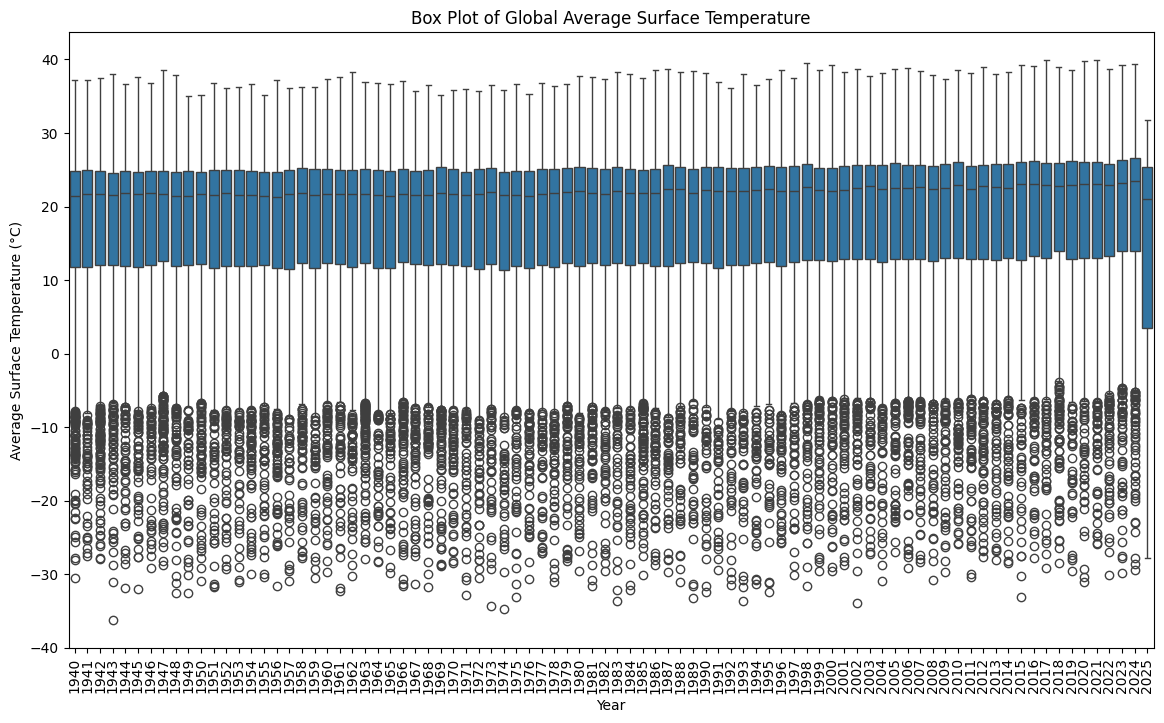

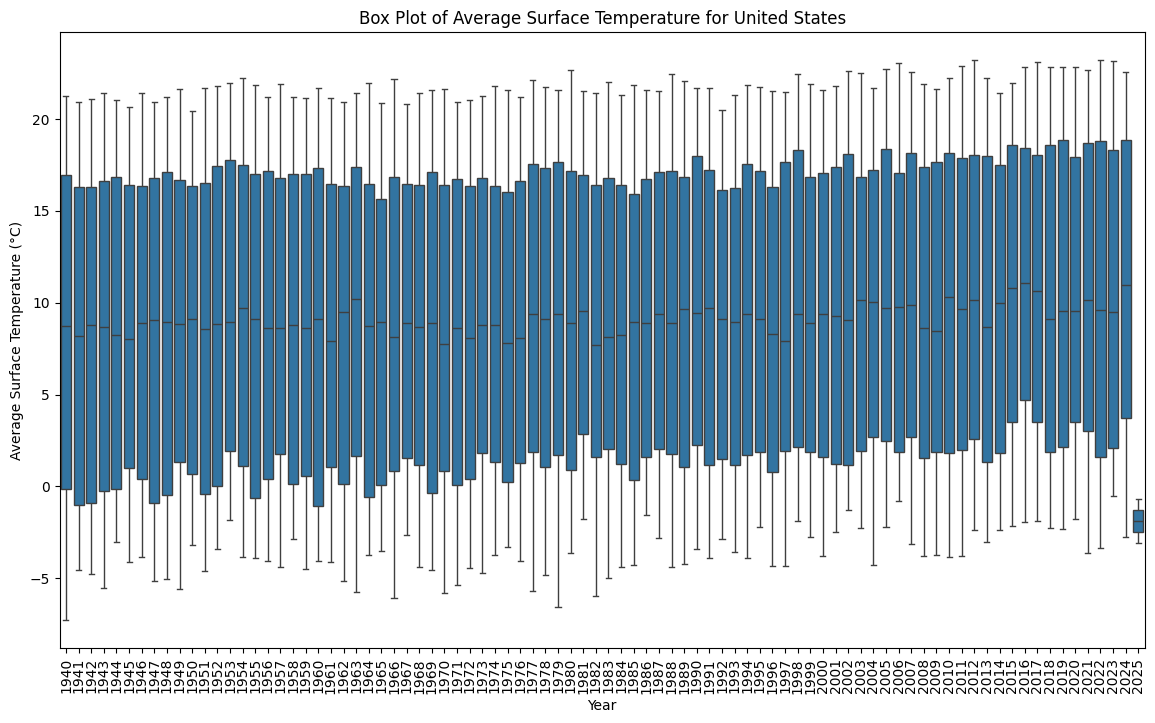

In [7]:
def plot_boxplot_avg_surface_temp(df, country_name=None):
    """
    Plot a box plot for average surface temperatures across all years.
    If country_name is provided, filter data for that country.
    """
    if country_name:
        df_filtered = df[df['Country Name'] == country_name]
        title = f"Box Plot of Average Surface Temperature for {country_name}"
    else:
        df_filtered = df
        title = "Box Plot of Global Average Surface Temperature"
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_filtered, x='year', y='Average surface temperature')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Average Surface Temperature (°C)")
    plt.xticks(rotation=90)
    plt.show()

# Example: Box plot for global average surface temperature
plot_boxplot_avg_surface_temp(df2)

# Example: Box plot for average surface temperature in a specific country (e.g., United States)
plot_boxplot_avg_surface_temp(df2, country_name="United States")

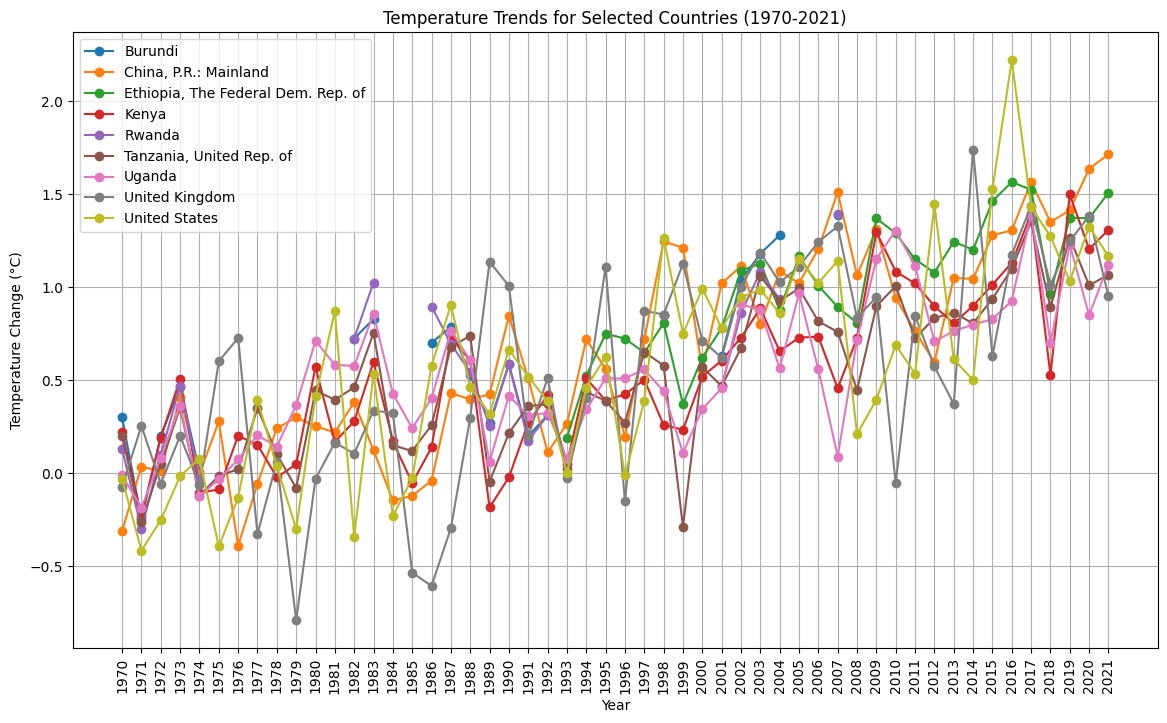

In [8]:
def plot_temperature_trends(df, countries, title, ylabel):
    plt.figure(figsize=(14, 8))
    for country in countries:
        country_data = df[df['Country Name'] == country]
        years = df.columns[4:]  # Extract year columns (1970 to 2021)
        temperatures = country_data.iloc[:, 4:].values.flatten()
        plt.plot(years, temperatures, marker='o', label=country)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

countries = ["Burundi", "China, P.R.: Mainland", "Ethiopia, The Federal Dem. Rep. of", "Kenya", "Rwanda", "Tanzania, United Rep. of", "Uganda", "United Kingdom", "United States"]
plot_temperature_trends(df1, countries, "Temperature Trends for Selected Countries (1970-2021)", "Temperature Change (°C)")

### Model Building and Evaluation

In [9]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    return model, y_pred

# Prepare data for modeling
features = df1.iloc[:, 4:-1]  # Temperature data from 1970 to 2020
target = df1['2021']  # Target variable (temperature change in 2021)
features = features.fillna(features.mean())
target = target.fillna(target.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train and evaluate Linear Regression model
linear_model = LinearRegression()
linear_model, y_pred_linear = train_and_evaluate_model(X_train, X_test, y_train, y_test, linear_model)

# Train and evaluate Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model, y_pred_rf = train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_model)

Mean Absolute Error (MAE): 0.2175001047439321
Mean Squared Error (MSE): 0.08569246506253646
R-squared (R²): 0.7061049029324619
Mean Absolute Error (MAE): 0.18615912230800477
Mean Squared Error (MSE): 0.065458007452518
R-squared (R²): 0.7755019949529273


In [10]:
def predict_future_temperatures(df, start_year, end_year):
    predictions = {}
    for country in df['Country Name'].unique():
        country_data = df[df['Country Name'] == country]
        years = np.array(country_data.columns[4:-1], dtype=int)
        X = years.reshape(-1, 1)
        y = country_data.iloc[:, 4:-1].values.flatten()
        mask = ~np.isnan(y)
        X = X[mask]
        y = y[mask]
        model = LinearRegression()
        model.fit(X, y)
        future_years = np.array(range(start_year, end_year + 1)).reshape(-1, 1)
        future_predictions = model.predict(future_years)
        predictions[country] = future_predictions
    predictions_df = pd.DataFrame(predictions).T
    predictions_df.columns = [str(year) for year in range(start_year, end_year + 1)]
    predictions_df['Country Name'] = predictions_df.index
    predictions_df = predictions_df.reset_index(drop=True)
    return predictions_df

predictions_df = predict_future_temperatures(df1, 2022, 2030)
print(predictions_df.head())

       2022      2023      2024      2025      2026      2027      2028  \
0  1.357372  1.384909  1.412445  1.439982  1.467519  1.495055  1.522592   
1  1.686318  1.728535  1.770752  1.812970  1.855187  1.897404  1.939621   
2  1.812630  1.851246  1.889862  1.928478  1.967094  2.005710  2.044326   
3  0.957765  0.976365  0.994964  1.013563  1.032162  1.050761  1.069360   
4  1.911048  1.951796  1.992543  2.033291  2.074038  2.114786  2.155534   

       2029      2030                  Country Name  
0  1.550129  1.577665  Afghanistan, Islamic Rep. of  
1  1.981839  2.024056                       Albania  
2  2.082942  2.121557                       Algeria  
3  1.087959  1.106558                American Samoa  
4  2.196281  2.237029      Andorra, Principality of  


#### Saving preditions

In [11]:
predictions_df.to_csv("average_surface_temperature_predictions_2022_2030.csv", index=False)

### Visualised Predictions

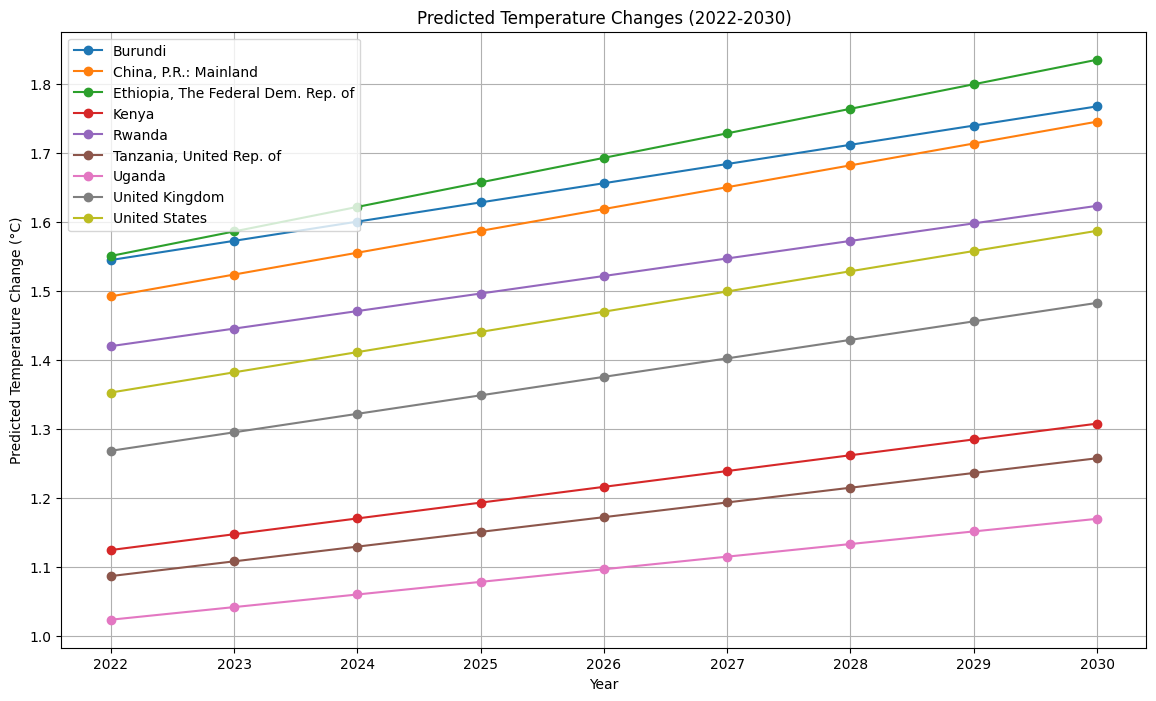

In [12]:
def plot_predictions(predictions_df, countries, title, ylabel):
    filtered_predictions = predictions_df[predictions_df['Country Name'].isin(countries)]
    plt.figure(figsize=(14, 8))
    for country in countries:
        country_data = filtered_predictions[filtered_predictions['Country Name'] == country]
        plt.plot(range(2022, 2031), country_data.iloc[:, :-1].values.flatten(), marker='o', label=country)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(predictions_df, countries, "Predicted Temperature Changes (2022-2030)", "Predicted Temperature Change (°C)")

Shape of dataframe: (227, 56)

Columns in dataframe: ['ObjectId', 'Country Name', 'Unit', 'Change ', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

First 5 rows of dataframe:
   ObjectId                  Country Name            Unit  \
0         1  Afghanistan, Islamic Rep. of  Degree Celsius   
1         2                       Albania  Degree Celsius   
2         3                       Algeria  Degree Celsius   
3         4                American Samoa  Degree Celsius   
4         5      Andorra, Principality of  Degree Celsius   

                      Change    1970   1971   1972   1973   1974   1975  ...  \
0  Surfa

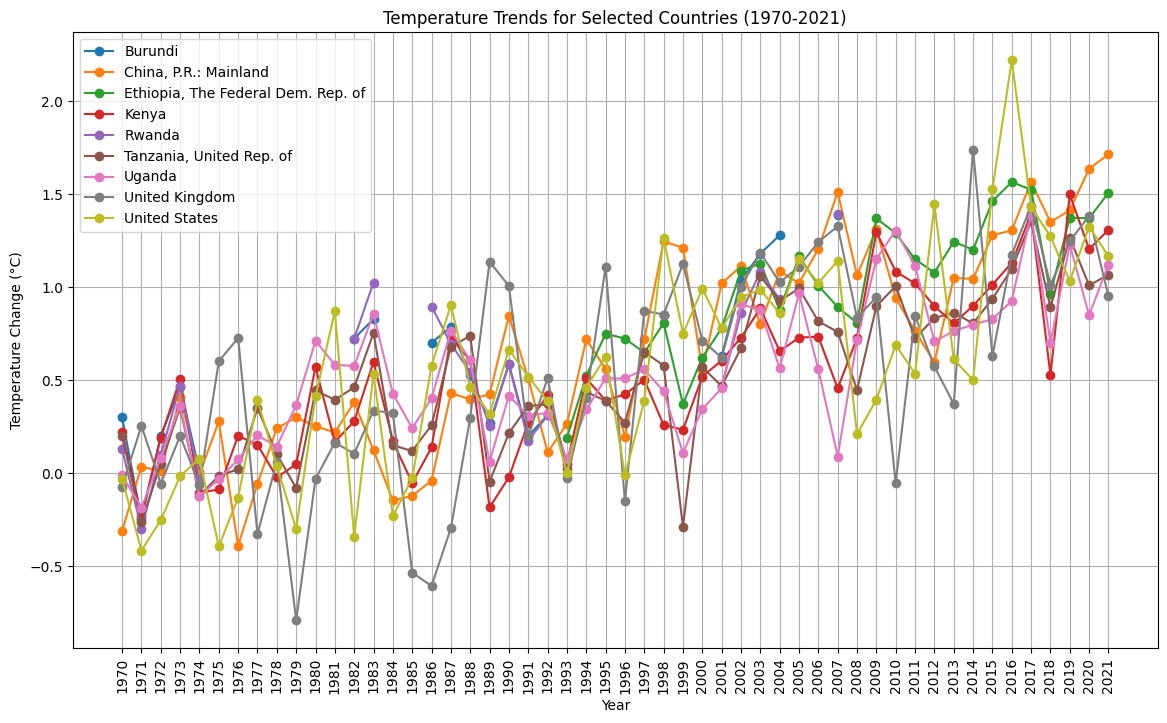

Mean Absolute Error (MAE): 0.2175001047439321
Mean Squared Error (MSE): 0.08569246506253646
R-squared (R²): 0.7061049029324619
Mean Absolute Error (MAE): 0.18615912230800477
Mean Squared Error (MSE): 0.065458007452518
R-squared (R²): 0.7755019949529273


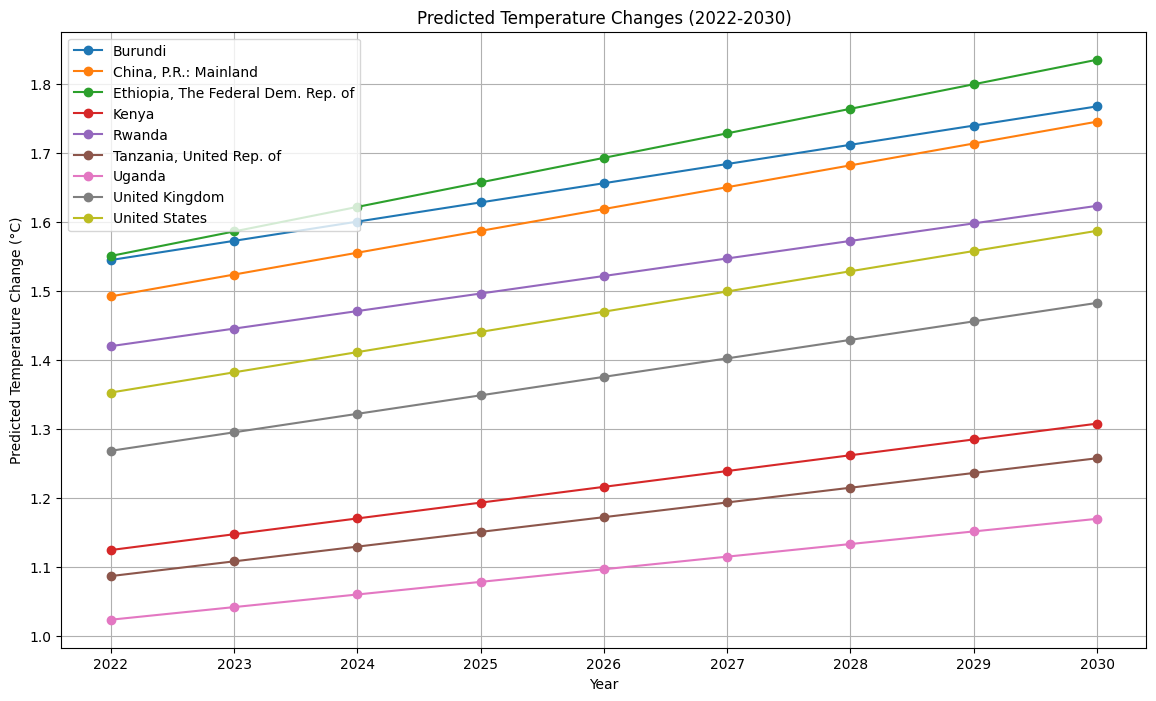

NameError: name 'perform_cross_validation' is not defined

In [13]:
def main():
    df1, df2 = load_data(file_path1, file_path2)
    perform_eda(df1)
    perform_eda(df2)
    plot_temperature_trends(df1, countries, "Temperature Trends for Selected Countries (1970-2021)", "Temperature Change (°C)")
    train_and_evaluate_model(X_train, X_test, y_train, y_test, linear_model)
    train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_model)
    predictions_df = predict_future_temperatures(df1, 2022, 2030)
    predictions_df.to_csv("average_surface_temperature_predictions_2022_2030.csv", index=False)
    plot_predictions(predictions_df, countries, "Predicted Temperature Changes (2022-2030)", "Predicted Temperature Change (°C)")
    perform_cross_validation(features, target)
    prophet_forecast(years, y)

if __name__ == "__main__":
    main()

### Line Graph for Global Average Temperature

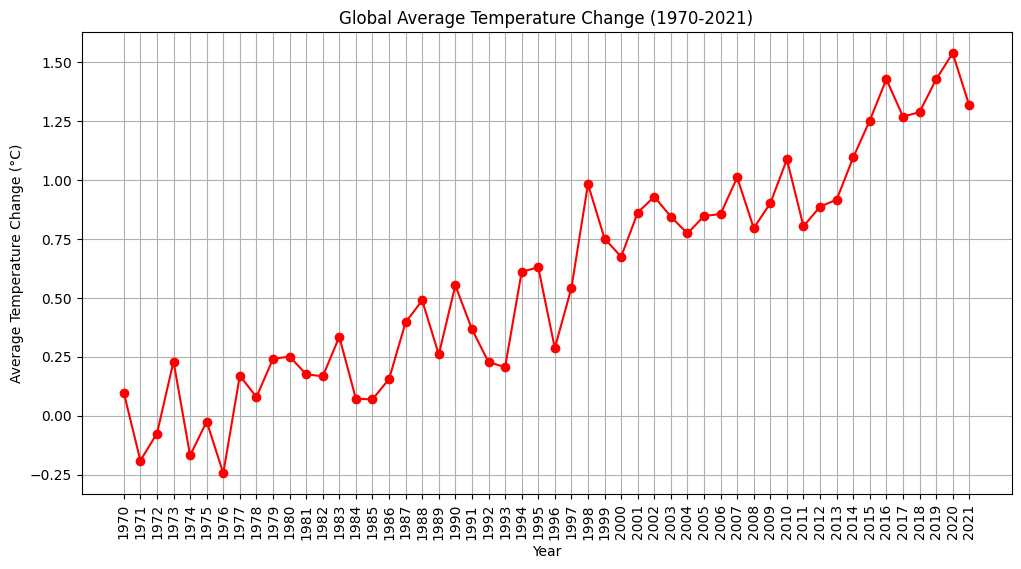

In [ ]:
def plot_global_avg_temperature(df, title="Global Average Temperature Over Time", ylabel="Average Temperature (°C)"):
    """
    Plot a line graph for global average temperature over time.
    """
    # Calculate global average temperature for each year
    global_avg_temps = df.iloc[:, 4:].mean()
    
    # Plot the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(global_avg_temps.index, global_avg_temps.values, marker='o', color='red')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

# Example: Line graph for global average temperature
plot_global_avg_temperature(df1, "Global Average Temperature Change (1970-2021)", "Average Temperature Change (°C)")

### Line Graph for Country-Specific Average Temperature

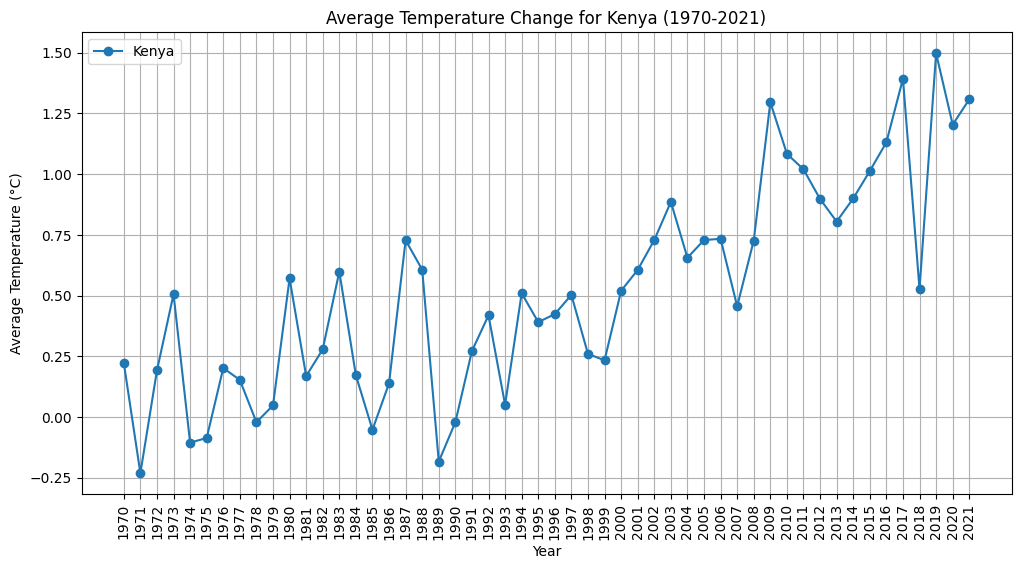

In [ ]:
def plot_country_avg_temperature(df, country_name, title=None, ylabel="Average Temperature (°C)"):
    """
    Plot a line graph for average temperature of a specific country over time.
    """
    # Filter data for the selected country
    country_data = df[df['Country Name'] == country_name]
    
    # Extract years and temperatures
    years = df.columns[4:]
    temperatures = country_data.iloc[:, 4:].values.flatten()
    
    # Plot the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(years, temperatures, marker='o', label=country_name)
    plt.title(title or f"Average Temperature Change for {country_name} (1970-2021)")
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

# Example: Line graph for average temperature in the Kenya
plot_country_avg_temperature(df1, "Kenya")

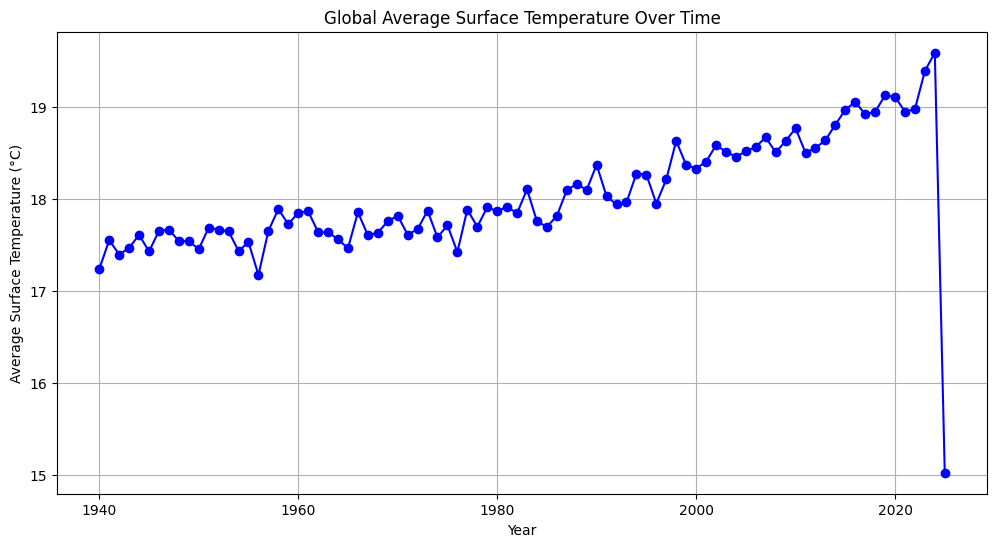

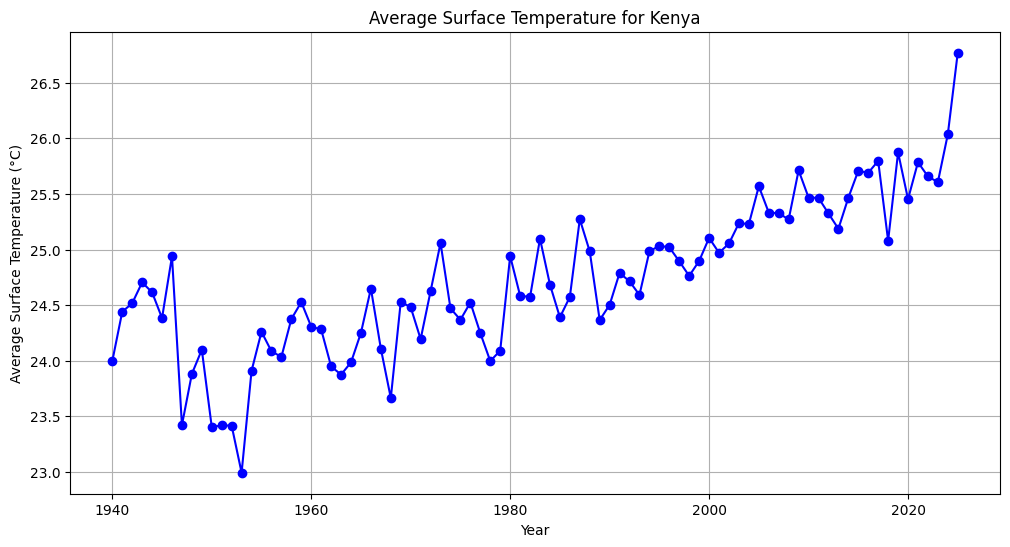

In [ ]:
def plot_avg_surface_temperature(df, country_name=None, title=None, ylabel="Average Surface Temperature (°C)"):
    """
    Plot a line graph for average surface temperature over time.
    If country_name is provided, filter data for that country.
    """
    if country_name:
        df_filtered = df[df['Country Name'] == country_name]
        title = title or f"Average Surface Temperature for {country_name}"
    else:
        df_filtered = df
        title = title or "Global Average Surface Temperature Over Time"
    
    # Calculate average surface temperature for each year
    avg_temps = df_filtered.groupby('year')['Average surface temperature'].mean()
    
    # Plot the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(avg_temps.index, avg_temps.values, marker='o', color='blue')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

# Example: Line graph for global average surface temperature
plot_avg_surface_temperature(df2)

# Example: Line graph for average surface temperature in the Kenya
plot_avg_surface_temperature(df2, country_name="Kenya")

### Cross Validation

In [ ]:
def perform_cross_validation(X, y, n_splits=5):
    """
    Perform time series cross-validation using TimeSeriesSplit.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    print("Average MSE across all folds:", np.mean(mse_scores))

### Prophet Forecast Function

In [ ]:
def prophet_forecast(df, country):
    """
    Forecast future temperatures using Prophet for a specific country.
    """
    # Filter data for the selected country
    country_data = df[df['Country Name'] == country]
    
    # Prepare data for Prophet
    years = country_data.columns[4:-1].astype(int)
    temperatures = country_data.iloc[:, 4:-1].values.flatten()
    
    prophet_data = pd.DataFrame({
        'ds': pd.to_datetime(years, format='%Y'),
        'y': temperatures
    })
    
    # Train Prophet model
    model = Prophet()
    model.fit(prophet_data)
    
    # Make future predictions
    future = model.make_future_dataframe(periods=9, freq='Y')
    forecast = model.predict(future)
    
    # Plot the forecast
    model.plot(forecast)
    plt.title(f"Prophet Forecast for {country} (2022-2030)")
    plt.xlabel("Year")
    plt.ylabel("Temperature Change (°C)")
    plt.show()

Shape of dataframe: (227, 56)

Columns in dataframe: ['ObjectId', 'Country Name', 'Unit', 'Change ', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

First 5 rows of dataframe:
   ObjectId                  Country Name            Unit  \
0         1  Afghanistan, Islamic Rep. of  Degree Celsius   
1         2                       Albania  Degree Celsius   
2         3                       Algeria  Degree Celsius   
3         4                American Samoa  Degree Celsius   
4         5      Andorra, Principality of  Degree Celsius   

                      Change    1970   1971   1972   1973   1974   1975  ...  \
0  Surfa

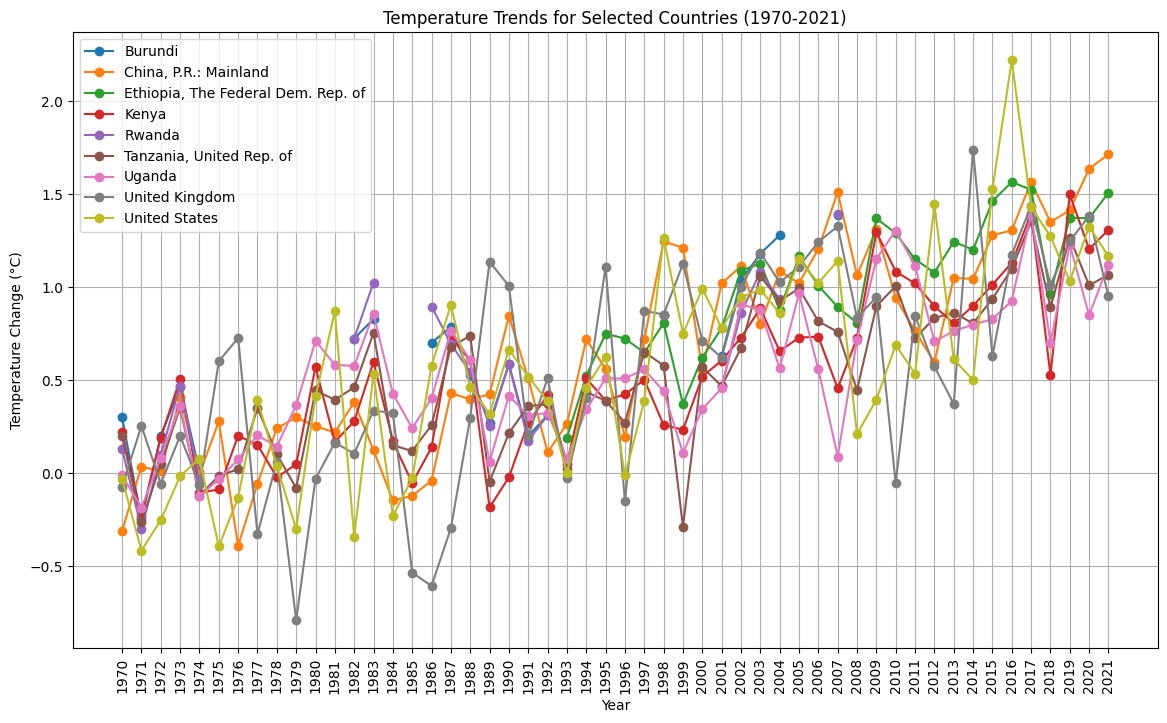

Mean Absolute Error (MAE): 0.2175001047439321
Mean Squared Error (MSE): 0.08569246506253646
R-squared (R²): 0.7061049029324619
Mean Absolute Error (MAE): 0.18615912230800477
Mean Squared Error (MSE): 0.065458007452518
R-squared (R²): 0.7755019949529273


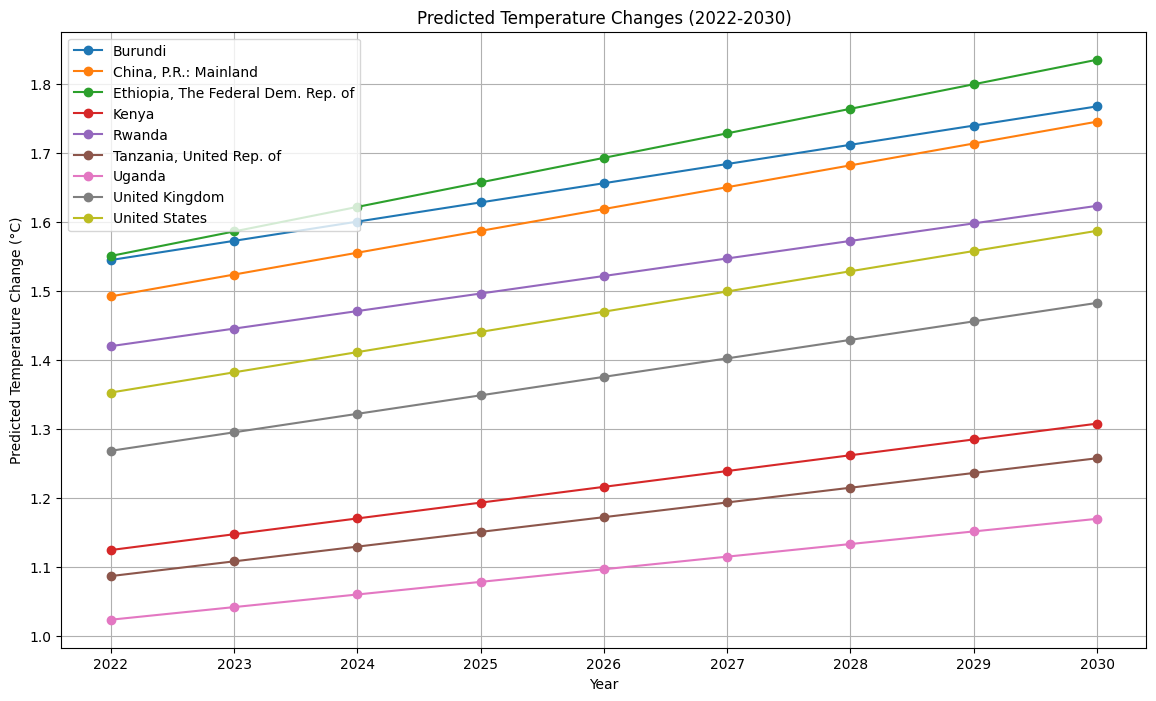


Performing Cross-Validation...
Average MSE across all folds: 0.30237838905359316

Performing Prophet Forecast...


19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\chris.mutuku\AppData\Local\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


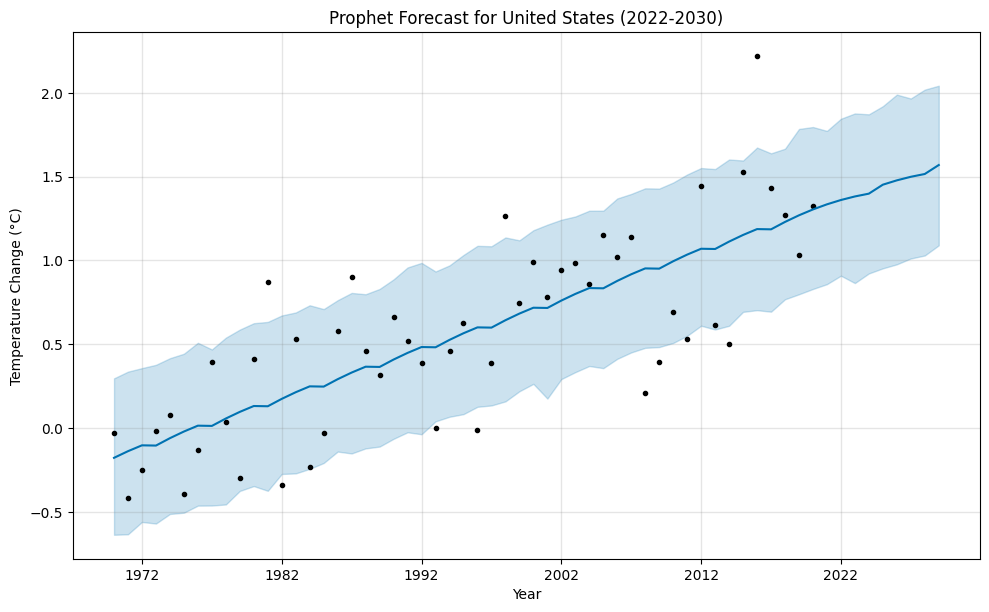

In [ ]:
def main():
    # Load data
    df1, df2 = load_data(file_path1, file_path2)
    
    # Perform EDA
    perform_eda(df1)
    perform_eda(df2)
    
    # Plot temperature trends
    plot_temperature_trends(df1, countries, "Temperature Trends for Selected Countries (1970-2021)", "Temperature Change (°C)")
    
    # Prepare data for modeling
    features = df1.iloc[:, 4:-1]  # Temperature data from 1970 to 2020
    target = df1['2021']  # Target variable (temperature change in 2021)
    features = features.fillna(features.mean())
    target = target.fillna(target.mean())
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Train and evaluate Linear Regression model
    linear_model = LinearRegression()
    linear_model, y_pred_linear = train_and_evaluate_model(X_train, X_test, y_train, y_test, linear_model)
    
    # Train and evaluate Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model, y_pred_rf = train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_model)
    
    # Predict future temperatures
    predictions_df = predict_future_temperatures(df1, 2022, 2030)
    predictions_df.to_csv("average_surface_temperature_predictions_2022_2030.csv", index=False)
    
    # Plot predictions
    plot_predictions(predictions_df, countries, "Predicted Temperature Changes (2022-2030)", "Predicted Temperature Change (°C)")
    
    # Perform cross-validation
    print("\nPerforming Cross-Validation...")
    perform_cross_validation(features, target)
    
    # Perform Prophet forecast for a specific country
    print("\nPerforming Prophet Forecast...")
    prophet_forecast(df1, "United States")  # Example: Forecast for the United States

if __name__ == "__main__":
    main()

In [ ]:
def prepare_prophet_data(df, country_name=None):
    """
    Prepare data for Prophet model.
    If country_name is provided, filter data for that country.
    """
    if country_name:
        df_filtered = df[df['Country Name'] == country_name]
    else:
        df_filtered = df
    
    # Aggregate to yearly averages
    df_yearly = df_filtered.groupby('year')['Average surface temperature'].mean().reset_index()
    
    # Prepare data for Prophet
    prophet_data = df_yearly.rename(columns={'year': 'ds', 'Average surface temperature': 'y'})
    prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')  # Convert year to datetime
    return prophet_data

In [ ]:
def train_prophet_model(prophet_data):
    """
    Train a Prophet model on the prepared data.
    """
    model = Prophet()
    model.fit(prophet_data)
    return model

In [ ]:
def generate_prophet_forecast(model, periods=10):
    """
    Generate forecasts for the specified number of periods (years).
    """
    future = model.make_future_dataframe(periods=periods, freq='Y')  # Forecast for the next 10 years
    forecast = model.predict(future)
    return forecast

In [ ]:
def plot_prophet_forecast(model, forecast, title="Prophet Forecast"):
    """
    Plot the Prophet forecast.
    """
    fig = model.plot(forecast)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Average Surface Temperature (°C)")
    plt.show()

20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\chris.mutuku\AppData\Local\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


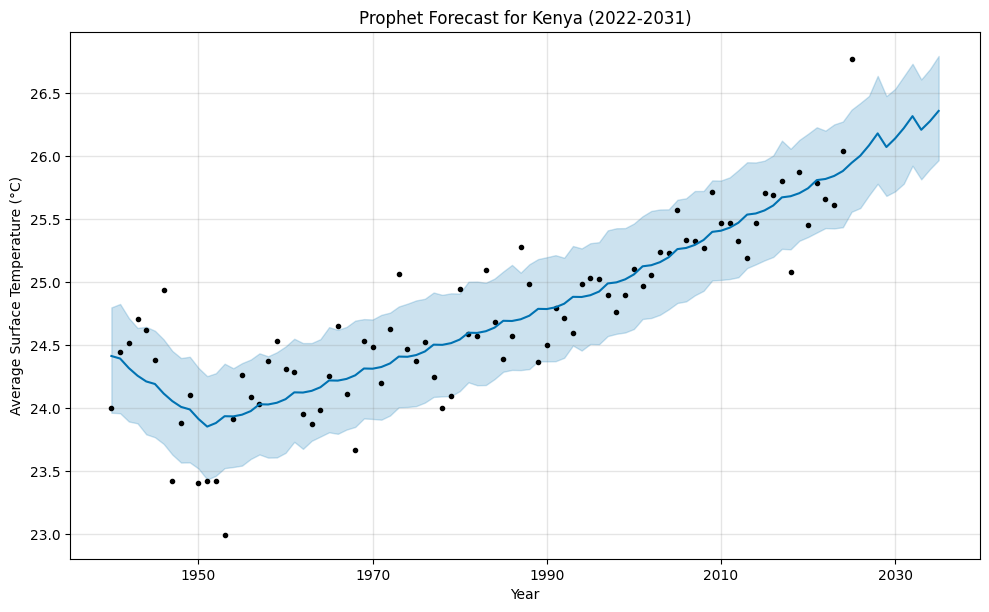

In [ ]:
# Prepare data for the Kenya
prophet_data = prepare_prophet_data(df2, country_name="Kenya")

# Train the Prophet model
model = train_prophet_model(prophet_data)

# Generate forecasts for the next 10 years
forecast = generate_prophet_forecast(model, periods=10)

# Plot the forecast
plot_prophet_forecast(model, forecast, title="Prophet Forecast for Kenya (2022-2031)")

20:14:02 - cmdstanpy - INFO - Chain [1] start processing
20:14:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\chris.mutuku\AppData\Local\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


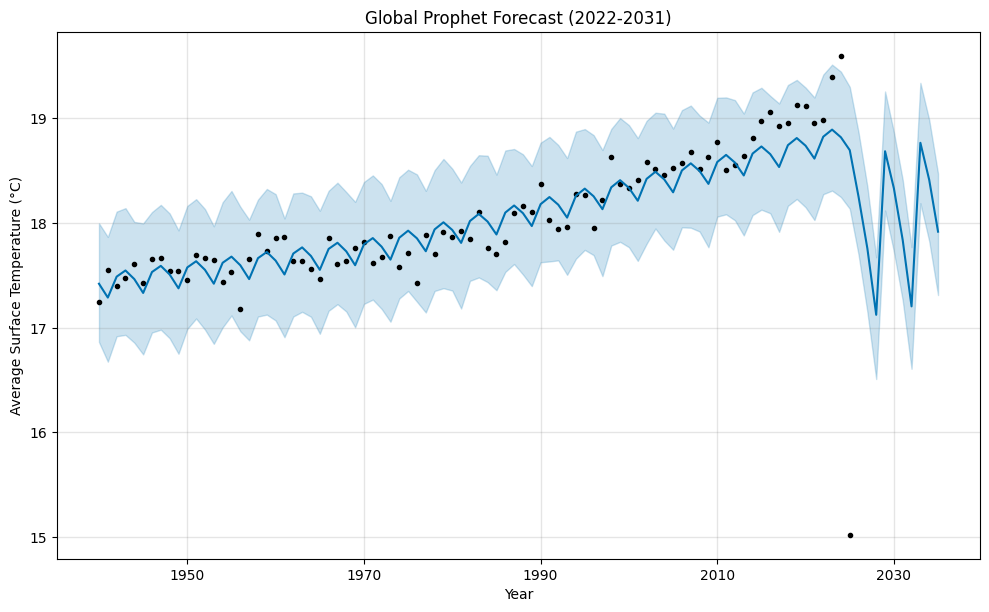

In [ ]:
# Prepare global data
prophet_data = prepare_prophet_data(df2)

# Train the Prophet model
model = train_prophet_model(prophet_data)

# Generate forecasts for the next 10 years
forecast = generate_prophet_forecast(model, periods=10)

# Plot the forecast
plot_prophet_forecast(model, forecast, title="Global Prophet Forecast (2022-2031)")

### Functions

Shape of dataframe: (227, 56)

Columns in dataframe: ['ObjectId', 'Country Name', 'Unit', 'Change ', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

First 5 rows of dataframe:
   ObjectId                  Country Name            Unit  \
0         1  Afghanistan, Islamic Rep. of  Degree Celsius   
1         2                       Albania  Degree Celsius   
2         3                       Algeria  Degree Celsius   
3         4                American Samoa  Degree Celsius   
4         5      Andorra, Principality of  Degree Celsius   

                      Change    1970   1971   1972   1973   1974   1975  ...  \
0  Surfa

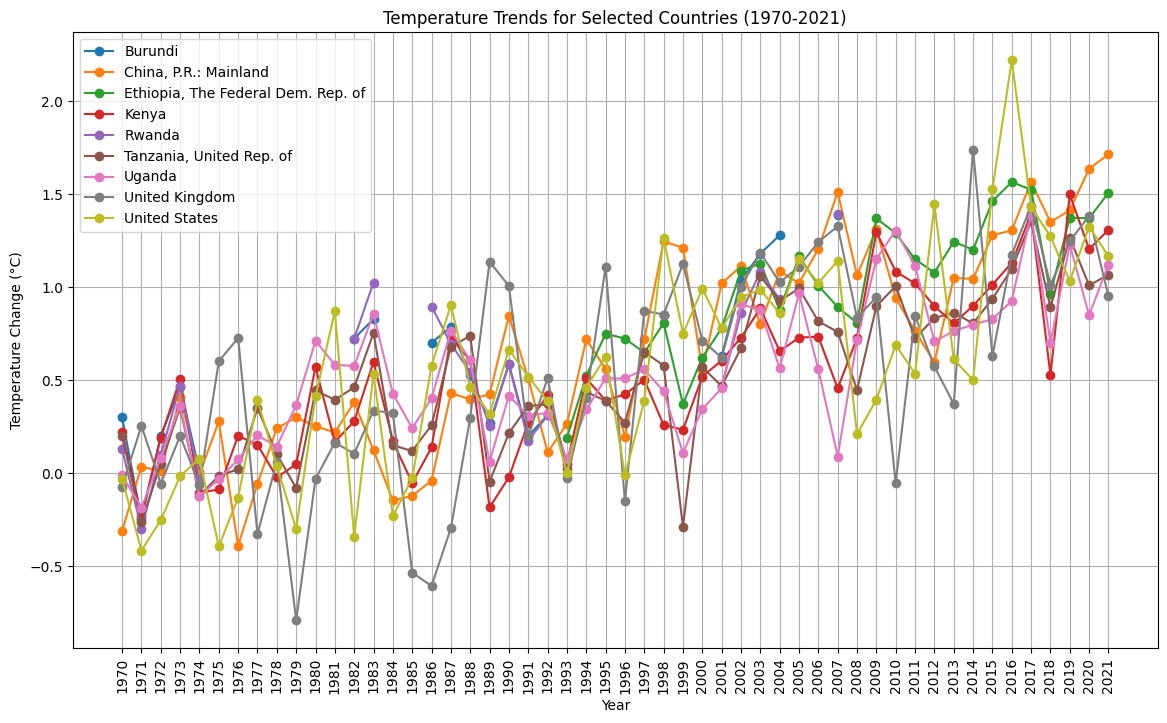

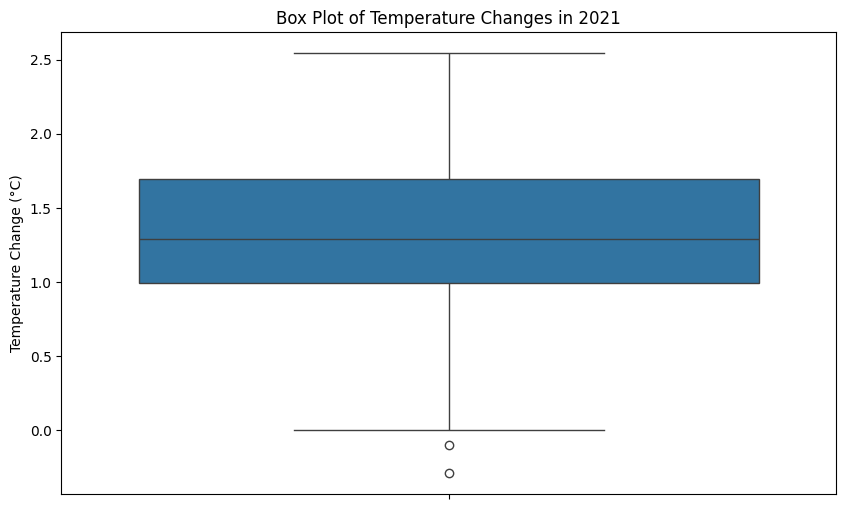

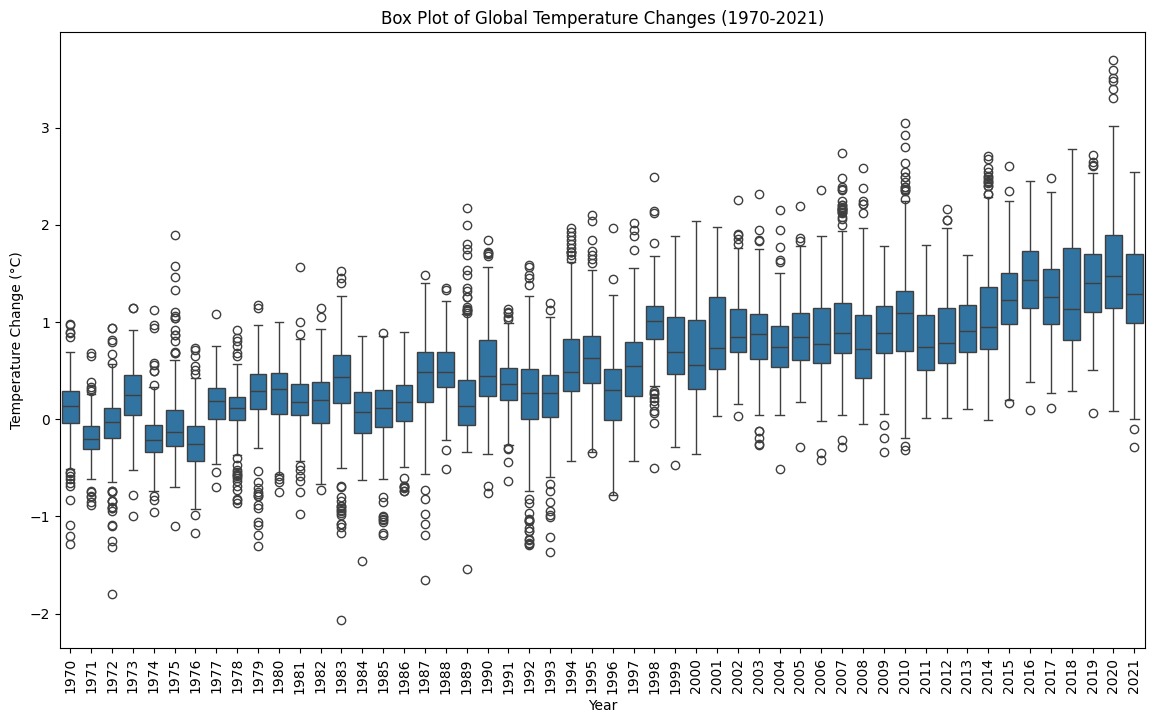

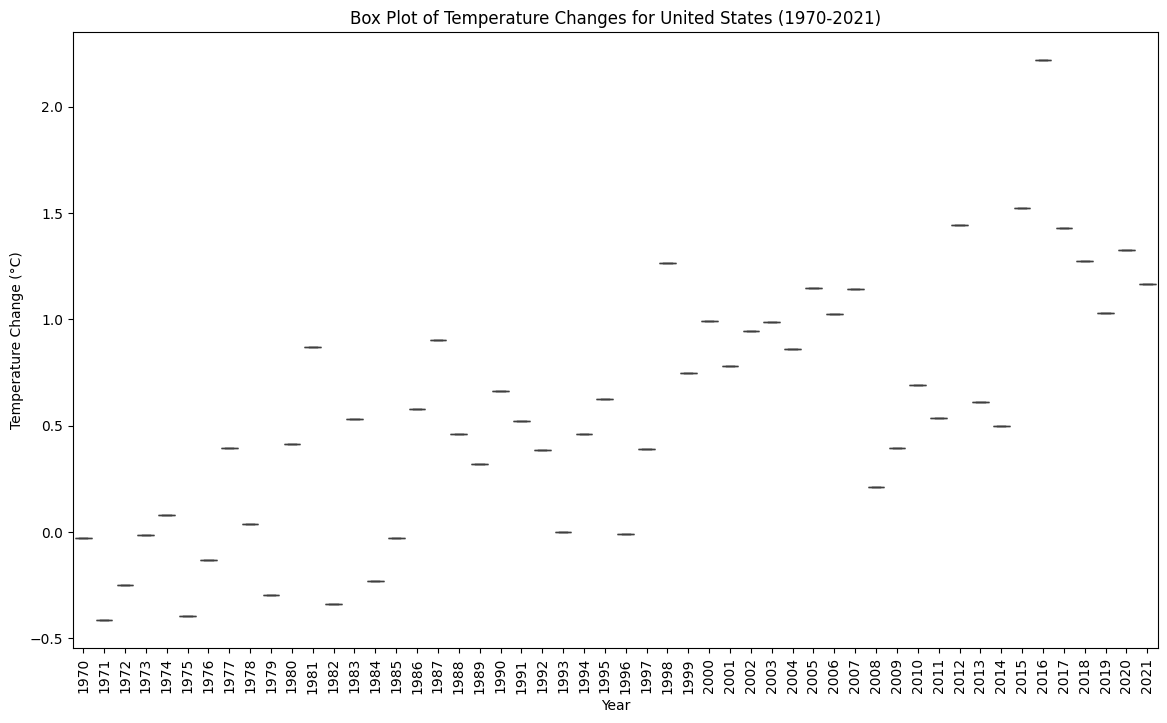

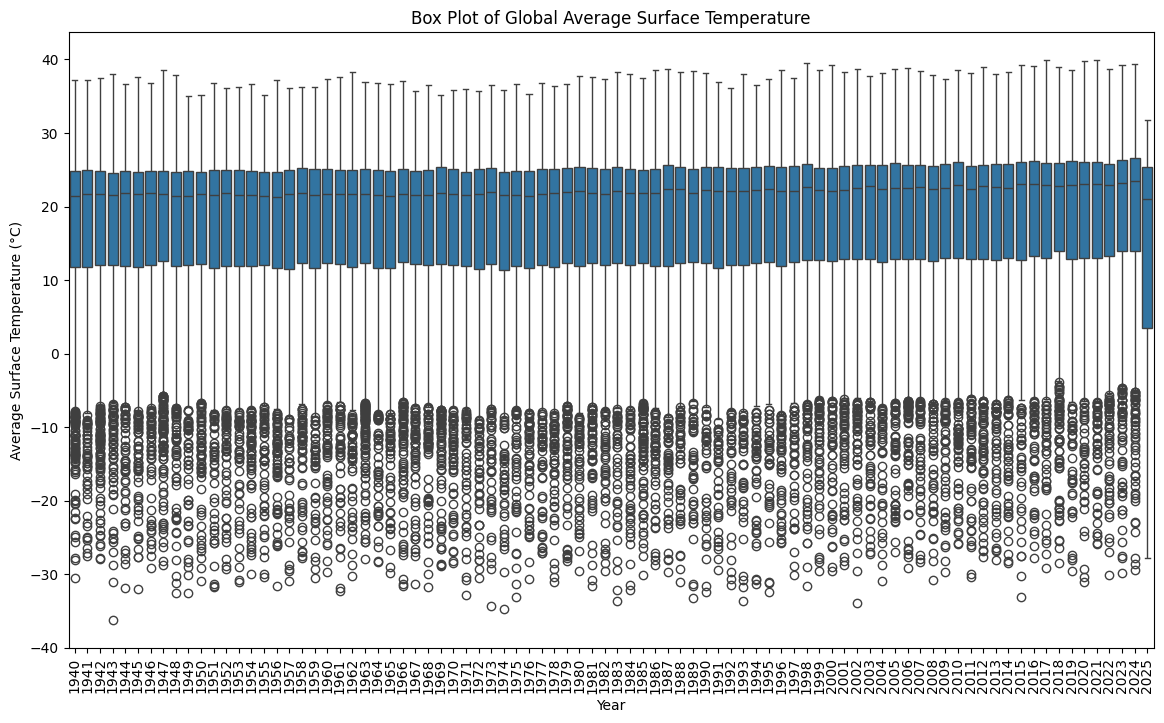

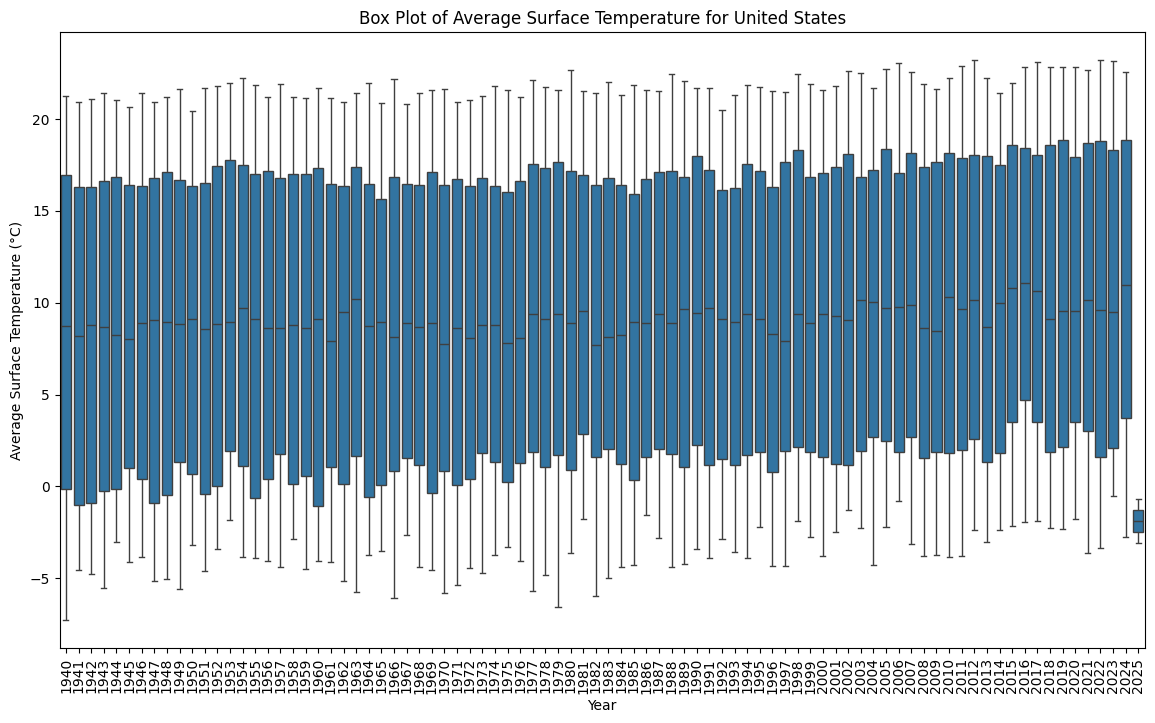

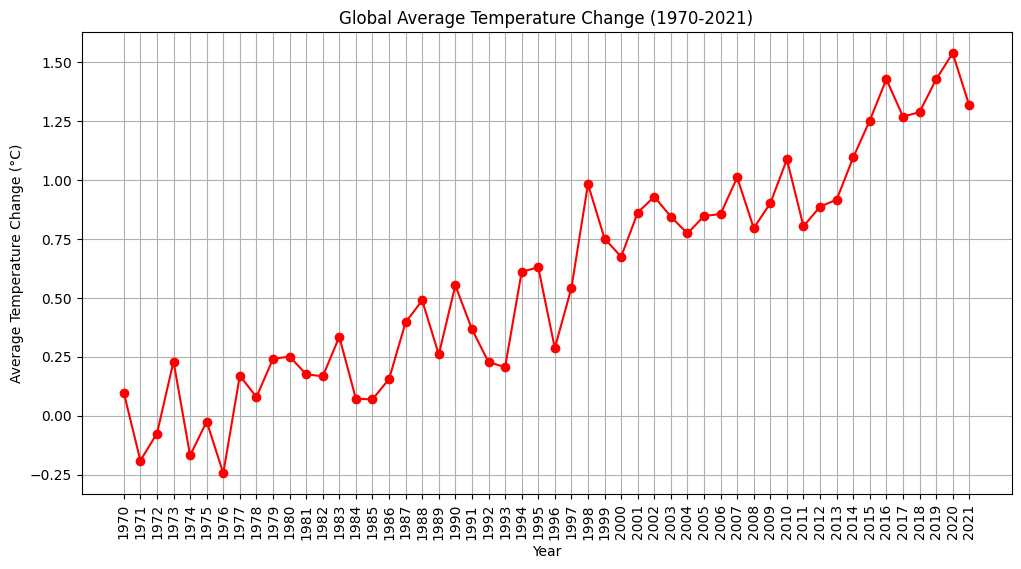

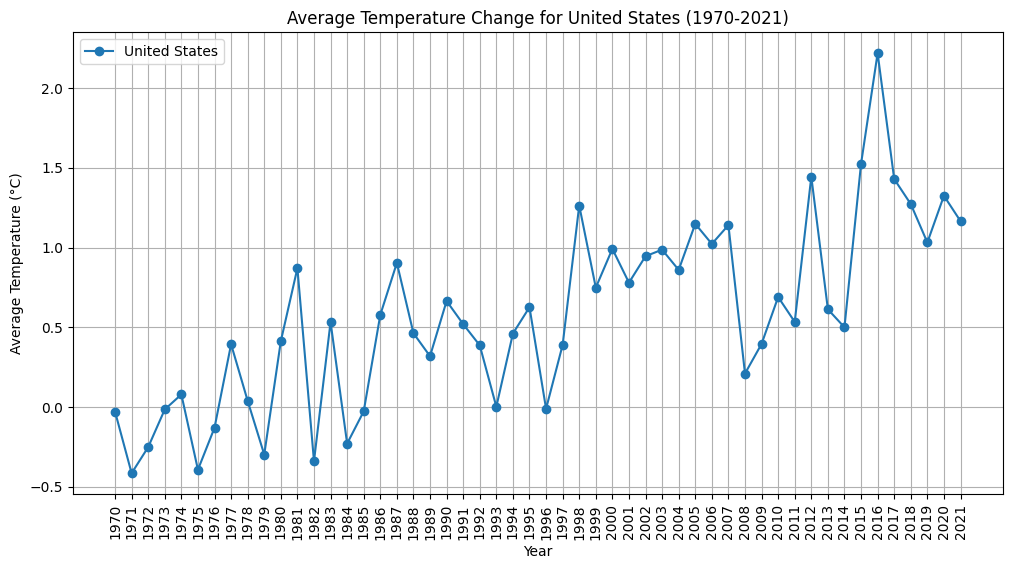

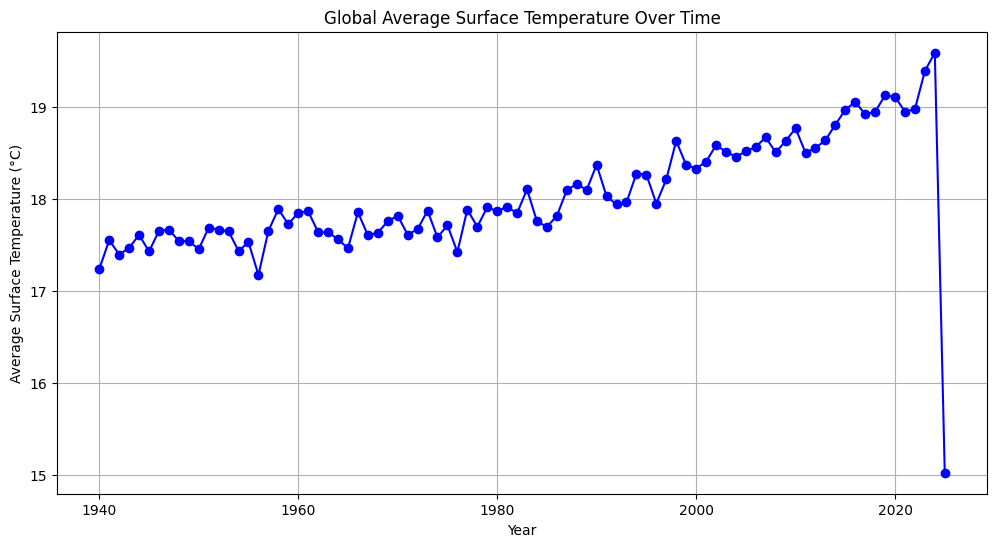

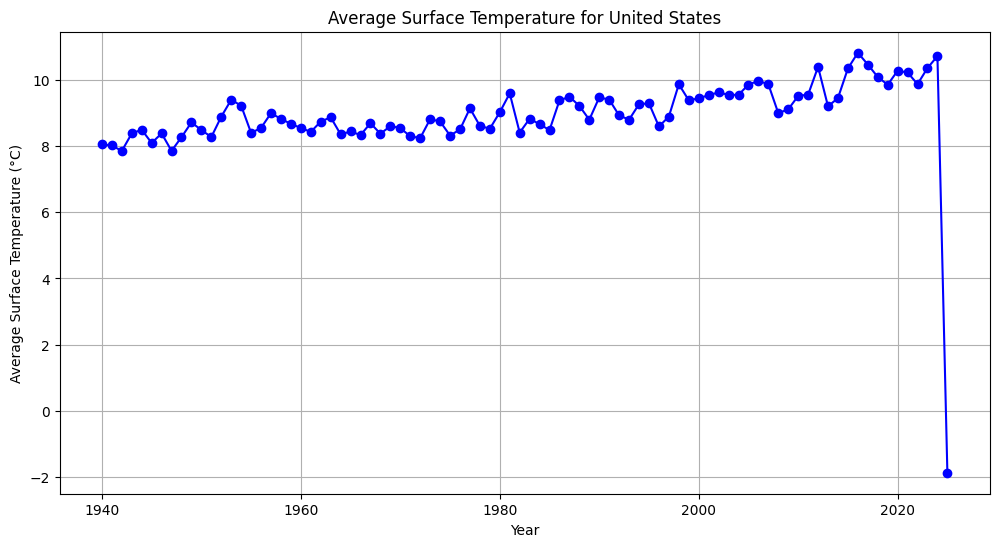

20:15:03 - cmdstanpy - INFO - Chain [1] start processing
20:15:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\chris.mutuku\AppData\Local\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


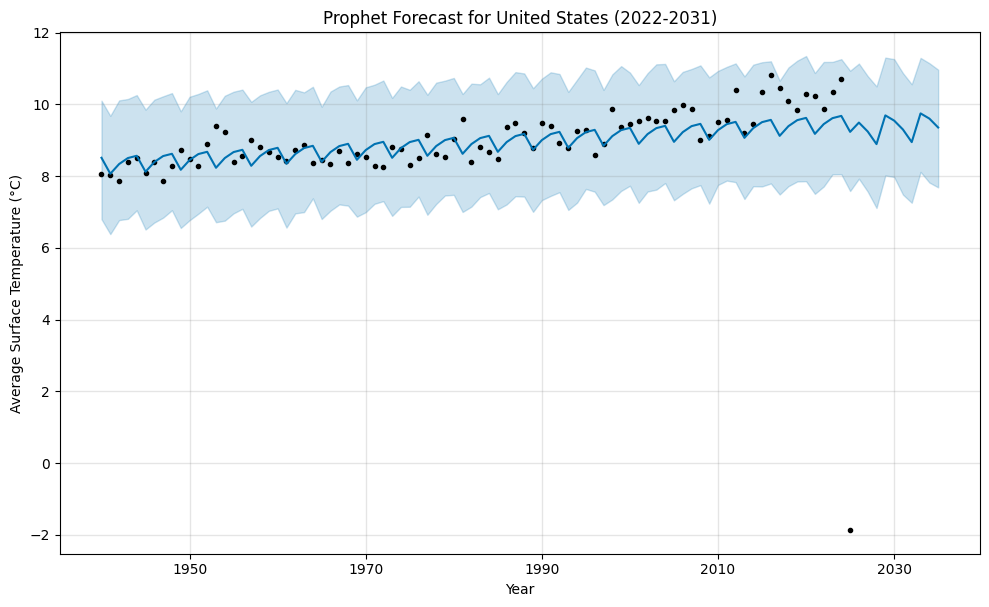

Mean Absolute Error (MAE): 0.2175001047439321
Mean Squared Error (MSE): 0.08569246506253646
R-squared (R²): 0.7061049029324619
Mean Absolute Error (MAE): 0.18615912230800477
Mean Squared Error (MSE): 0.065458007452518
R-squared (R²): 0.7755019949529273


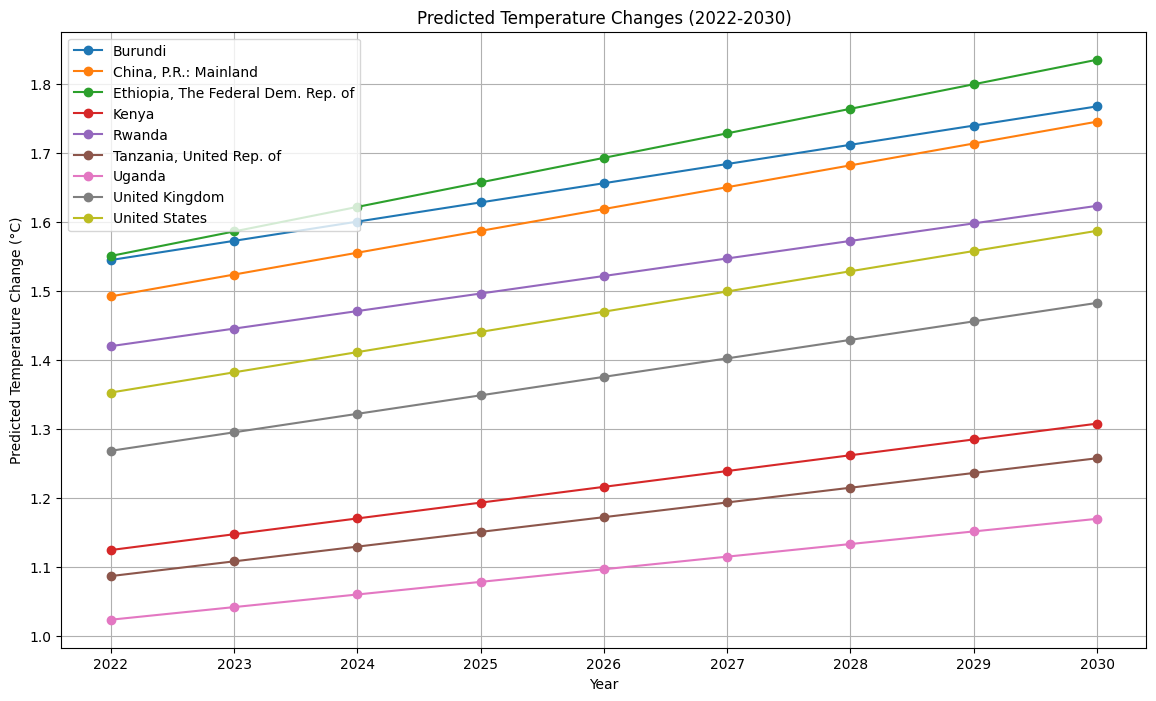


Performing Cross-Validation...
Average MSE across all folds: 0.30237838905359316


In [ ]:
def main():
    # Load data
    df1, df2 = load_data(file_path1, file_path2)
    
    # Perform EDA
    perform_eda(df1)
    perform_eda(df2)
    
    # Plot temperature trends
    plot_temperature_trends(df1, countries, "Temperature Trends for Selected Countries (1970-2021)", "Temperature Change (°C)")
    
    # Box plot for temperature changes in 2021
    plot_boxplot(df1, '2021', "Box Plot of Temperature Changes in 2021")
    
    # Box plot for global temperature changes
    plot_boxplot_all_years(df1)
    
    # Box plot for temperature changes in a specific country (e.g., United States)
    plot_boxplot_all_years(df1, country_name="United States")
    
    # Box plot for global average surface temperature
    plot_boxplot_avg_surface_temp(df2)
    
    # Box plot for average surface temperature in a specific country (e.g., United States)
    plot_boxplot_avg_surface_temp(df2, country_name="United States")
    
    # Line graph for global average temperature
    plot_global_avg_temperature(df1, "Global Average Temperature Change (1970-2021)", "Average Temperature Change (°C)")
    
    # Line graph for average temperature in a specific country (e.g., United States)
    plot_country_avg_temperature(df1, "United States")
    
    # Line graph for global average surface temperature
    plot_avg_surface_temperature(df2)
    
    # Line graph for average surface temperature in a specific country (e.g., United States)
    plot_avg_surface_temperature(df2, country_name="United States")
    
    # Prepare data for Prophet model (United States)
    prophet_data = prepare_prophet_data(df2, country_name="United States")
    
    # Train the Prophet model
    model = train_prophet_model(prophet_data)
    
    # Generate forecasts for the next 10 years
    forecast = generate_prophet_forecast(model, periods=10)
    
    # Plot the forecast
    plot_prophet_forecast(model, forecast, title="Prophet Forecast for United States (2022-2031)")
    
    # Prepare data for modeling
    features = df1.iloc[:, 4:-1]  # Temperature data from 1970 to 2020
    target = df1['2021']  # Target variable (temperature change in 2021)
    features = features.fillna(features.mean())
    target = target.fillna(target.mean())
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Train and evaluate Linear Regression model
    linear_model = LinearRegression()
    linear_model, y_pred_linear = train_and_evaluate_model(X_train, X_test, y_train, y_test, linear_model)
    
    # Train and evaluate Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model, y_pred_rf = train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_model)
    
    # Predict future temperatures
    predictions_df = predict_future_temperatures(df1, 2022, 2030)
    predictions_df.to_csv("average_surface_temperature_predictions_2022_2030.csv", index=False)
    
    # Plot predictions
    plot_predictions(predictions_df, countries, "Predicted Temperature Changes (2022-2030)", "Predicted Temperature Change (°C)")
    
    # Perform cross-validation
    print("\nPerforming Cross-Validation...")
    perform_cross_validation(features, target)

if __name__ == "__main__":
    main()

In [ ]:
pip install ipywidgets

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load the dataset
file_path1 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\all countries global temperature.csv"
df1 = pd.read_csv(file_path1)

# List of countries
countries = df1['Country Name'].unique().tolist()

# Dropdown for selecting a country
country_dropdown = widgets.Dropdown(
    options=countries,
    description='Select Country:',
    disabled=False,
)

# Button to trigger the plot
plot_button = widgets.Button(description="Plot Predictions")

# Output widget to display the plot
output = widgets.Output()

# Function to handle button click
def on_plot_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        selected_country = country_dropdown.value
        
        # Filter predictions for the selected country
        country_data = predictions_df[predictions_df['Country Name'] == selected_country]
        
        if not country_data.empty:
            # Plot predictions
            plt.figure(figsize=(10, 6))
            plt.plot(range(2022, 2031), country_data.iloc[:, :-1].values.flatten(), marker='o', label=selected_country)
            plt.title(f"Predicted Temperature Changes for {selected_country} (2022-2030)")
            plt.xlabel("Year")
            plt.ylabel("Predicted Temperature Change (°C)")
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print(f"No data available for {selected_country}.")

# Attach the function to the button
plot_button.on_click(on_plot_button_click)

# Display the widgets
display(country_dropdown, plot_button, output)

Dropdown(description='Select Country:', options=('Afghanistan, Islamic Rep. of', 'Albania', 'Algeria', 'Americ…

Button(description='Plot Predictions', style=ButtonStyle())

Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# List of countries
countries = df1['Country Name'].unique().tolist()

# Dropdown for selecting a country
country_dropdown = widgets.Dropdown(
    options=countries,
    description='Select Country:',
    disabled=False,
)

# Checkbox for multiple countries
multi_country_checkbox = widgets.Checkbox(
    value=False,
    description='Select Multiple Countries',
    disabled=False,
)

# Multiselect for multiple countries
multi_country_select = widgets.SelectMultiple(
    options=countries,
    description='Select Countries:',
    disabled=True,
)

# Button to trigger the plot
plot_button = widgets.Button(description="Plot Predictions")

# Output widget to display the plot
output = widgets.Output()

# Function to handle checkbox change
def on_checkbox_change(change):
    multi_country_select.disabled = not change['new']

# Attach the function to the checkbox
multi_country_checkbox.observe(on_checkbox_change, names='value')

# Function to handle button click
def on_plot_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        
        if multi_country_checkbox.value:
            selected_countries = multi_country_select.value
        else:
            selected_countries = [country_dropdown.value]
        
        plt.figure(figsize=(12, 6))
        for country in selected_countries:
            country_data = predictions_df[predictions_df['Country Name'] == country]
            if not country_data.empty:
                plt.plot(range(2022, 2031), country_data.iloc[:, :-1].values.flatten(), marker='o', label=country)
            else:
                print(f"No data available for {country}.")
        
        if selected_countries:
            plt.title("Predicted Temperature Changes (2022-2030)")
            plt.xlabel("Year")
            plt.ylabel("Predicted Temperature Change (°C)")
            plt.legend()
            plt.grid()
            plt.show()

# Attach the function to the button
plot_button.on_click(on_plot_button_click)

# Display the widgets
display(country_dropdown, multi_country_checkbox, multi_country_select, plot_button, output)

Dropdown(description='Select Country:', options=('Afghanistan, Islamic Rep. of', 'Albania', 'Algeria', 'Americ…

Checkbox(value=False, description='Select Multiple Countries')

SelectMultiple(description='Select Countries:', disabled=True, options=('Afghanistan, Islamic Rep. of', 'Alban…

Button(description='Plot Predictions', style=ButtonStyle())

Output()

In [14]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load the dataset
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df2 = pd.read_csv(file_path2)

# List of countries
countries = df2['Country Name'].unique().tolist()

# Dropdown for selecting a country
country_dropdown = widgets.Dropdown(
    options=countries,
    description='Select Country:',
    disabled=False,
)

# Checkbox for multiple countries
multi_country_checkbox = widgets.Checkbox(
    value=False,
    description='Select Multiple Countries',
    disabled=False,
)

# Multiselect for multiple countries
multi_country_select = widgets.SelectMultiple(
    options=countries,
    description='Select Countries:',
    disabled=True,
)

# Button to trigger the plot
plot_button = widgets.Button(description="Plot Predictions")

# Output widget to display the plot
output = widgets.Output()

# Function to handle checkbox change
def on_checkbox_change(change):
    multi_country_select.disabled = not change['new']

# Attach the function to the checkbox
multi_country_checkbox.observe(on_checkbox_change, names='value')

# Function to handle button click
def on_plot_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        
        if multi_country_checkbox.value:
            selected_countries = multi_country_select.value
        else:
            selected_countries = [country_dropdown.value]
        
        plt.figure(figsize=(12, 6))
        for country in selected_countries:
            country_data = df2[df2['Country Name'] == country]
            if not country_data.empty:
                yearly_avg = country_data.groupby('year')['Average surface temperature'].mean()
                plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=country)
            else:
                print(f"No data available for {country}.")
        
        if selected_countries:
            plt.title("Average Surface Temperature Over Time")
            plt.xlabel("Year")
            plt.ylabel("Average Surface Temperature (°C)")
            plt.legend()
            plt.grid()
            plt.show()

# Attach the function to the button
plot_button.on_click(on_plot_button_click)

# Display the widgets
display(country_dropdown, multi_country_checkbox, multi_country_select, plot_button, output)

Dropdown(description='Select Country:', options=('Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andor…

Checkbox(value=False, description='Select Multiple Countries')

SelectMultiple(description='Select Countries:', disabled=True, options=('Afghanistan', 'Albania', 'Algeria', '…

Button(description='Plot Predictions', style=ButtonStyle())

Output()

Dropdown(description='Select Country:', options=('Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andor…

IntSlider(value=1940, continuous_update=False, description='Select Year:', max=2025, min=1940)

Button(description='Plot Predictions', style=ButtonStyle())

Output()

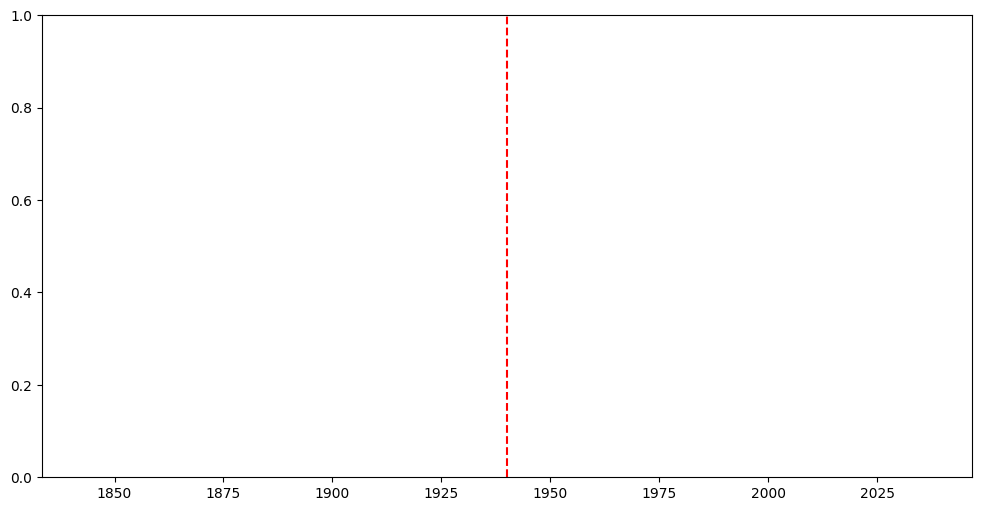

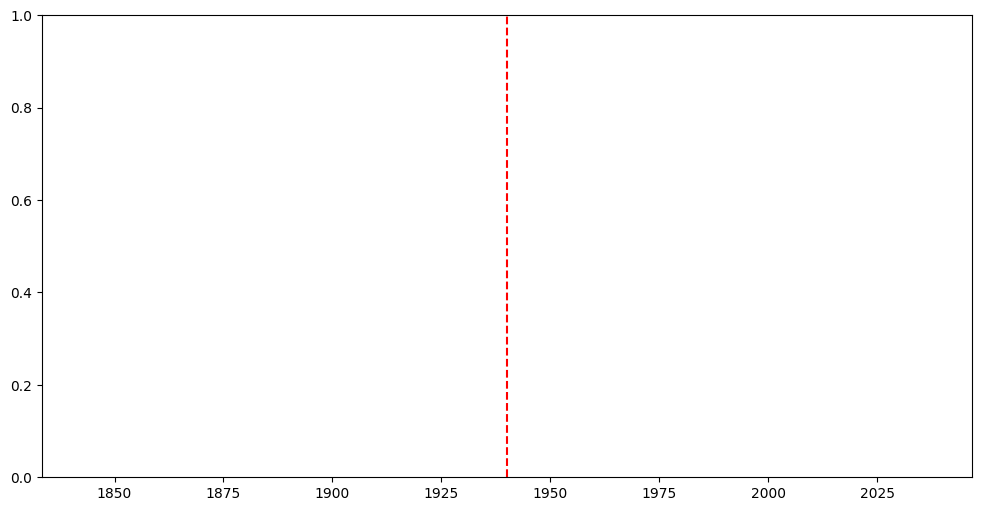

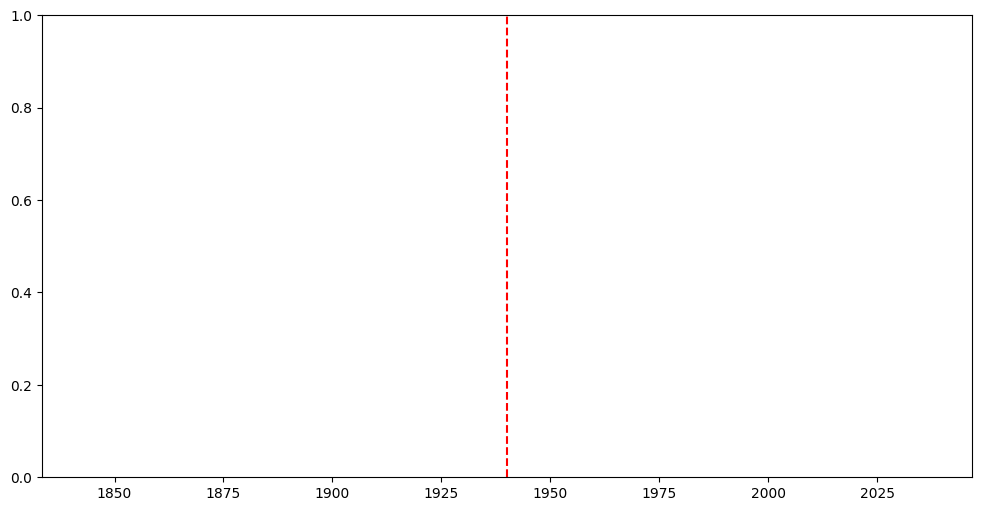

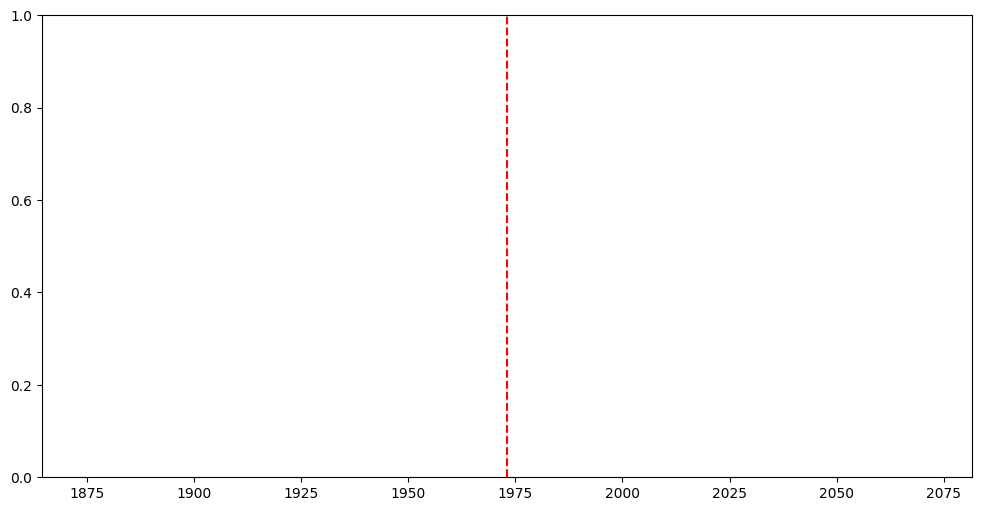

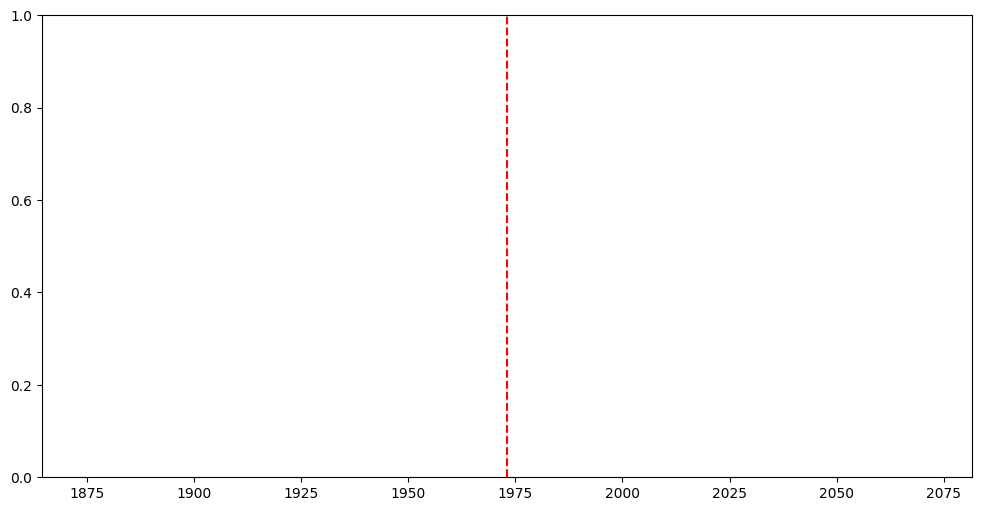

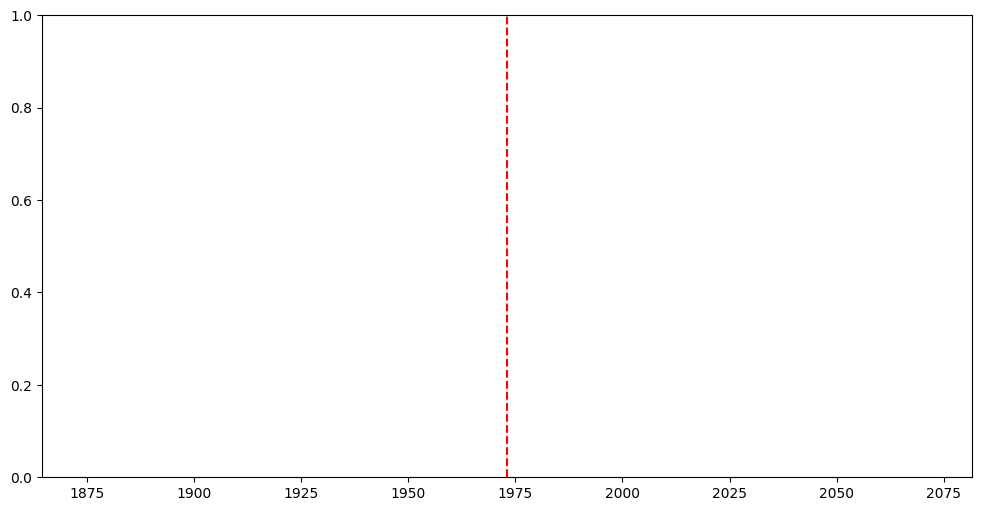

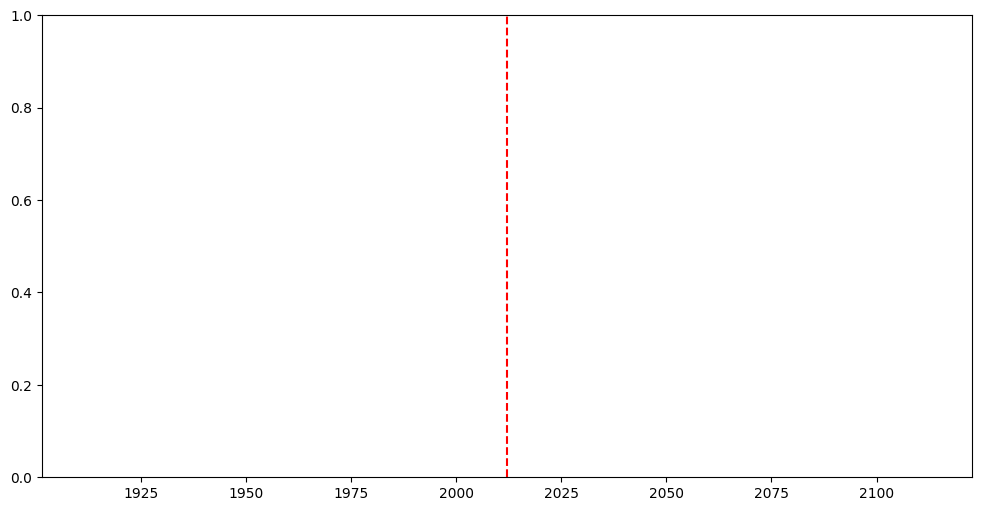

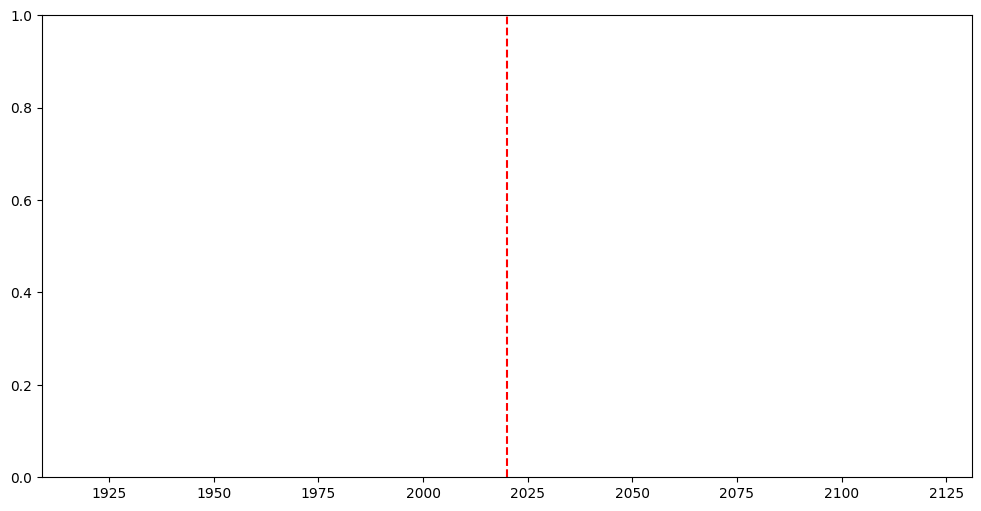

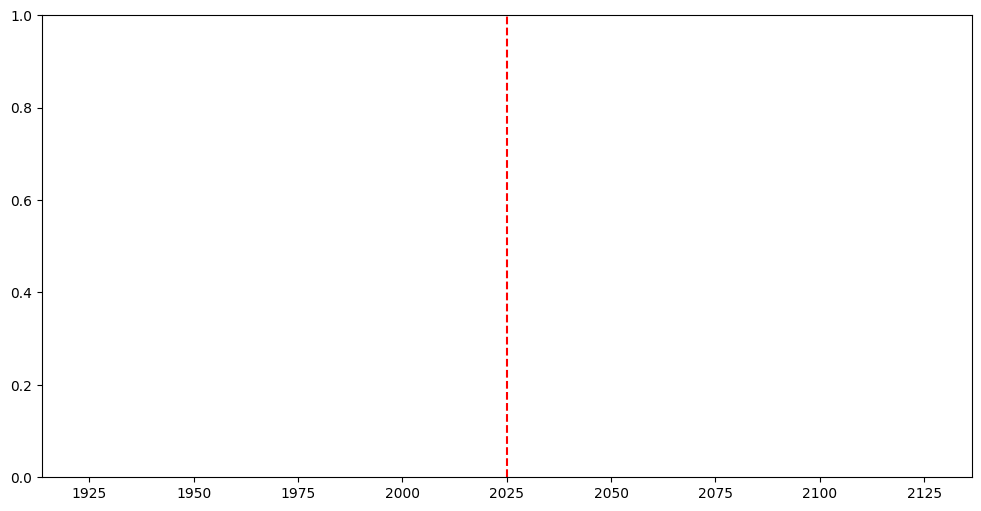

In [15]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load the dataset
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df2 = pd.read_csv(file_path2)

# Calculate global average temperature for each year
global_avg_temp = df2.groupby('year')['Average surface temperature'].mean().reset_index()

# List of countries
countries = df2['Country Name'].unique().tolist()

# Dropdown for selecting a country
country_dropdown = widgets.Dropdown(
    options=countries,
    description='Select Country:',
    disabled=False,
)

# Slider for selecting a year
year_slider = widgets.IntSlider(
    min=global_avg_temp['year'].min(),
    max=global_avg_temp['year'].max(),
    step=1,
    description='Select Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Button to trigger the plot
plot_button = widgets.Button(description="Plot Predictions")

# Output widget to display the plot and global temperature
output = widgets.Output()

# Function to handle button click
def on_plot_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        
        # Get selected country and year
        selected_country = country_dropdown.value
        selected_year = year_slider.value
        
        # Display global average temperature for the selected year
        global_temp = global_avg_temp[global_avg_temp['year'] == selected_year]['Average surface temperature'].values[0]
        print(f"Global Average Temperature in {selected_year}: {global_temp:.2f} °C")
        
        # Filter data for the selected country
        country_data = df2[df2['Country Name'] == selected_country]
        
        if not country_data.empty:
            # Group by year and calculate the mean temperature
            yearly_avg = country_data.groupby('year')['Average surface temperature'].mean()
            
            # Plot the data
            plt.figure(figsize=(12, 6))
            plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=selected_country)
            plt.axvline(x=selected_year, color='r', linestyle='--', label=f"Selected Year: {selected_year}")
            plt.title(f"Average Surface Temperature for {selected_country}")
            plt.xlabel("Year")
            plt.ylabel("Average Surface Temperature (°C)")
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print(f"No data available for {selected_country}.")

# Attach the function to the button
plot_button.on_click(on_plot_button_click)

# Display the widgets
display(country_dropdown, year_slider, plot_button, output)

In [16]:
# Checkbox for multiple countries
multi_country_checkbox = widgets.Checkbox(
    value=False,
    description='Select Multiple Countries',
    disabled=False,
)

# Multiselect for multiple countries
multi_country_select = widgets.SelectMultiple(
    options=countries,
    description='Select Countries:',
    disabled=True,
)

# Function to handle checkbox change
def on_checkbox_change(change):
    multi_country_select.disabled = not change['new']

# Attach the function to the checkbox
multi_country_checkbox.observe(on_checkbox_change, names='value')

# Function to handle button click
def on_plot_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        
        # Get selected year
        selected_year = year_slider.value
        
        # Display global average temperature for the selected year
        global_temp = global_avg_temp[global_avg_temp['year'] == selected_year]['Average surface temperature'].values[0]
        print(f"Global Average Temperature in {selected_year}: {global_temp:.2f} °C")
        
        # Get selected countries
        if multi_country_checkbox.value:
            selected_countries = multi_country_select.value
        else:
            selected_countries = [country_dropdown.value]
        
        # Plot data for selected countries
        plt.figure(figsize=(12, 6))
        for country in selected_countries:
            country_data = df2[df2['Country Name'] == country]
            if not country_data.empty:
                yearly_avg = country_data.groupby('year')['Average surface temperature'].mean()
                plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=country)
            else:
                print(f"No data available for {country}.")
        
        # Add vertical line for selected year
        plt.axvline(x=selected_year, color='r', linestyle='--', label=f"Selected Year: {selected_year}")
        
        if selected_countries:
            plt.title("Average Surface Temperature Over Time")
            plt.xlabel("Year")
            plt.ylabel("Average Surface Temperature (°C)")
            plt.legend()
            plt.grid()
            plt.show()

# Attach the function to the button
plot_button.on_click(on_plot_button_click)

# Display the widgets
display(country_dropdown, multi_country_checkbox, multi_country_select, year_slider, plot_button, output)

Dropdown(description='Select Country:', options=('Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andor…

Checkbox(value=False, description='Select Multiple Countries')

SelectMultiple(description='Select Countries:', disabled=True, options=('Afghanistan', 'Albania', 'Algeria', '…

IntSlider(value=1940, continuous_update=False, description='Select Year:', max=2025, min=1940)

Button(description='Plot Predictions', style=ButtonStyle())

Output()